In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width: 100% !important}</style>'))

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\3593773758.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
from datetime import datetime
%matplotlib qt
%matplotlib inline

In [3]:
# ================== Global parameters for fonts & sizes =================
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'legend.fontsize': font_size, 
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': font_size, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

# ENERGY GENERATED CALCULATION

In [4]:
def check_energy_generated(data_site, date):
    """Get the amount of energy generated in a certain site in a certain day, unit kWh.

    Args:
        data_site (df): Cleaned D-PV time-series data, output of site_orgaize function
        date (str): date in focus

    Returns:
        energy_generated (float): Single value of the total energy generated in that day
        
    Adapted from part of Baran VVAr script. 
    
    It seems like he assumed the D-PV produces energy only between 7-17, 
    which may not be accurate in winter. Also, have it cleaned the negative power value? Not sure.
    TODO: Compare with Naomi and Tim's script.
    """
    
    #sh_idx = (data_site.index.hour>= 7) & (data_site.index.hour <= 17)
    #hour filter should not be necessary since outside of that hour, the power is zero anyway.
    
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    date_idx = data_site.index.date == date_dt
    energy_generated = data_site.loc[date_idx, 'power'].resample('h').mean().sum()/1000
    return energy_generated

# CHECK CLEAR SKY DAY


In [5]:
def check_clear_sky_day(date):
    """Check whether a certain date is a clear sky day based on the ghi data of that day. Needs ghi data.

    Args:
    date (str): dat ein YYYYMMDD format

    Returns:
    clear_sky_day (bool): is it a clear sky day or not
    
    Funcitons needed:
    - Get_timestamp_date_string
    - Separate_ghi_data
    - Detect_clear_sky_day

    Originally written by Tim for VWatt Curtailment Calculation.
    """
    dateFile = date[:4]+'_'+ date[5:7]
    ghi = pd.read_csv(file_path +'/sl_023034_' + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)
    ghi_df = separated_ghi_data[date]
    res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

    if res:
        #clear_sky_days.append(date)
        #overall_clear_sky_days_dict[dateFile].append(date)
        is_clear_sky_day = True
    else:
        is_clear_sky_day = False
    return is_clear_sky_day

# TRIPPING CURTAILMENT PROGRAM

In [6]:
import util #customized module to calculate the first derivative of the power data

In [7]:
# Function for getting cumulative count of 0 with reset on 1
def rcount(a):
    without_reset = (a == 0).cumsum()
    reset_at = (a == 1)
    overcount = np.maximum.accumulate(without_reset * reset_at)
    result = without_reset - overcount
    return result
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [78]:
def check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date):
    """Check the tripping response and the amount of energy curtailed bcs of tripping in kWh for certain data and site.

    Args:
    is_clear_sky_day (bool) : is the certain date a clear sky date or not
    c_id (str): c_id
    data_site (df): Cleaned D-PV time-series data, output of site_organize function
    unique_cids (df): Unique c_id and site_id data
    ac_cap (float): Inverter capacity in watt
    site_details (df): Site data from unsw_20190701_site_details.csv and unsw_20190701_circuit_details.csv
    date (str): Date in YYYYMMDD

    Returns:
    tripping_response (str): Yes or None, whether there is a tripping response by the inverter
    tripping_curt_energy (float): The amount of energy curtailed in that date and site in kWh
    estimation_method (str): Linear or polyfit. Polyfit is only used when it is a clear sky day and the fit passes some 
                             criterias. Otherwise always use linear.
    

    Originally written by Naomi. Some parts are modified to be compatible for SolA dataset input and implementation
    together with VVAr and VWatt script.
    
    TODO: Reconsider whether the cleaning part of Naomi's script is still necessary in Baran's SolA dataset.
    TODO: Compare between Naomi's and Tim's polyfit algorithm, pick the better one, upgrade it.
    """
    
    # In Naomi's script, the first step is to clean the data (remove duplicates, convert to numeric, etc). However, since the inputted data here is already cleaned, we directly use the data without further cleaning process.
    # Approx capacity factor value considered to be 'zero', e.g. less than 1% CF is zero.

    # List of connection types for filtering
    pv_list = ['pv_site_net', 'pv_site', 'pv_inverter_net']
    CF_ZERO_APPROX = 0.01

    # Approx cf derivative at which considered to be 'ramp'. That is, for at least a 10% change in capacity factor (ABSOLUTE!) expect to be ramping up or down.
    # Note, only applied 'next to' zeros. So should not capture shading effects.
    FIRST_DERIV_FALL_LIMIT = -0.05
    FIRST_DERIV_INCREASE_LIMIT = 0.05
    # For missing data check
    ALLOWED_MISSING_DATA_PERCENTAGE = 0.05
    # Average percentage of capacity at which a system must operate over the course of the day in order to be included in analysis
    VERY_LOW_OUTPUT_AVE_PERCENTAGE_CAPACITY = 0.05


    # Get data
    unaltered_data = pd.DataFrame({
        'c_id' : c_id,
        'v' : data_site['voltage'],
        'd' : data_site['duration'],
        'site_id' : unique_cids.loc[unique_cids['c_id'] == c_id, 'site_id'].iloc[0],
        'e' : data_site['energy'],
        'con_type' : site_details.loc[site_details['c_id'] == c_id, 'con_type'].iloc[0],
        'first_ac' : ac_cap/1000, #IDK what is this, but let's assume it is just the same with sum_ac, which is the inverter ac capacity
        'power_kW' : data_site['power']/1000,
        'reactive_power' : data_site['reactive_power'],
        'clean' : 'cleaned',
        'manufacturer' : site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].iloc[0],
        'model' : site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].iloc[0],
        'sum_ac' : ac_cap/1000,
        'time_offset' : float("nan")
    }, index = data_site.index)
    unaltered_data.index.rename('ts', inplace=True) 

    # rename energy column
    unaltered_data = unaltered_data.rename(columns = {'e' : 'energy', 'd':'duration', 'sum_ac':'ac'})
    # filter for clean
    unaltered_data = unaltered_data[unaltered_data['clean']=='cleaned']
    # Attempt to fix issues by sorting the index at the beginning
    unaltered_data = unaltered_data.sort_index()
    # Change name to t_stamp
    unaltered_data.index.name = 't_stamp'
    # Add time by seconds from start of the day
    unaltered_data['hrs'] = unaltered_data.index.hour
    unaltered_data['min'] = unaltered_data.index.minute
    unaltered_data['sec'] = unaltered_data.index.second
    unaltered_data['time_in_seconds'] = unaltered_data['hrs'] * 60 * 60 + unaltered_data['min'] * 60 + unaltered_data['sec']

    # Get list of time_intervals
    time_interval_list = unaltered_data['duration'].drop_duplicates().tolist()

    # ********************* Further data cleaning [START] *********************
    # Check for missing data issues
    # TODO - this may not longer work since the Solar Analytics data can contain a mix of 60s and 5s data
    # Flag sites with too much missing data (based on threshold), need to also keep the duration
    missing_data_df = pd.DataFrame({'num_data_pts': unaltered_data.groupby('c_id')['energy'].count(), 'duration': unaltered_data.groupby('c_id')['duration'].first()}).reset_index()
    # We now have two possible time intervals: 30s or 60s.
    # Therefore, we need to run twice?
    for time_interval in time_interval_list:
        # Expected number of time periods
        num_time_periods = 24 * 60 * (60 / time_interval)
        # Get the minimum number of data points required in order to have enough data (i.e. not lots of missing data)
        missing_data_threshold = num_time_periods * (1 - ALLOWED_MISSING_DATA_PERCENTAGE)
        missing_data_df['missing_data_flag'] = np.nan
        missing_data_df.loc[(missing_data_df['num_data_pts'] <= missing_data_threshold) & missing_data_df['duration']==time_interval , 'missing_data_flag'] = 1.0
    # Merge information about missing data back onto time series df
    unaltered_data = unaltered_data.reset_index().merge(missing_data_df, on='c_id', how='left').set_index('t_stamp')
    # Filter unaltered data for only sites with sufficient data points
    unaltered_data = unaltered_data[unaltered_data['missing_data_flag'] != 1.0]

    # Filter for PV only
    unaltered_data = unaltered_data[unaltered_data['con_type'].isin(pv_list)]

    # First fix duratoin_x / duration_y problem. Not sure where it is coming from
    # I don't know why, but there is duration_x and duration_y. Drop one and rename the other
    unaltered_data = unaltered_data.drop(['duration_x'], axis=1)
    unaltered_data = unaltered_data.rename(columns={'duration_y': 'duration'})

    # Open _circuit_details_for_editing.csv file for sunrise/set times
    assist_df = pd.DataFrame({
        'c_id' : [c_id],
        'energy_day' : [float("nan")],
        'energy_night' : [float("nan")],
        'con_type' : [site_details.loc[site_details['c_id'] == c_id, 'con_type'].iloc[0]],
        'sunrise' : ['2/09/2019  6:06:06'], #later need to be edited
        'sunset' : ['2/09/2019  19:28:19'], #later need to be edited
        'min_power' : [data_site['power'].min()/1000],
        'max_power' : [data_site['power'].max()/1000],
        'polarity' : [site_details.loc[site_details['c_id'] == c_id, 'polarity'].iloc[0]],
        'frac_day' : [float('nan')],
        'old_con_type' : [float('nan')],
        'con_type_change' : [float('nan')],
        'site_id' : [unique_cids.loc[unique_cids['c_id'] == c_id, 'site_id'].iloc[0]]
    })

    # Check for PV sites with very low output and remove them
    get_site_ac_df = unaltered_data[['site_id', 'first_ac', 'ac']]
    get_site_ac_df = get_site_ac_df.drop_duplicates(subset='site_id')
    # merge keeping only the site_ids in the time series df.
    assist_df = assist_df.merge(get_site_ac_df, left_on='site_id', right_on='site_id', how='right')

    # Check whether c_ids operated at less than an average of 5% capacity
    # Compare using max power output compared with first_ac.
    max_p_df = pd.DataFrame({'max_p_kW': unaltered_data.groupby('c_id')['power_kW'].max(), 'first_ac' : unaltered_data.groupby('c_id')['first_ac'].first()})
    max_p_df['low_output_flag'] = np.nan
    max_p_df.loc[max_p_df['max_p_kW'] < VERY_LOW_OUTPUT_AVE_PERCENTAGE_CAPACITY * max_p_df['first_ac'] , 'low_output_flag'] = 1
    # Copy c_ids to a column (from index)
    max_p_df['c_id'] = max_p_df.index
    # Get list of c_ids to be excluded
    c_ids_to_WITHOUT_low_output = max_p_df[max_p_df['low_output_flag'] != 1]
    c_ids_to_WITHOUT_low_output = c_ids_to_WITHOUT_low_output['c_id'].tolist()

    # Only keep sites that have enough output
    unaltered_data = unaltered_data[unaltered_data['c_id'].isin(c_ids_to_WITHOUT_low_output)]
    # ********************* Further data cleaning [END] *********************

    # Get assist_df with c_id as index
    assist_df_c_id = assist_df.set_index('c_id')

    # Get c_id list
    c_id_list = unaltered_data['c_id'].drop_duplicates().tolist()
    # Set up output_df
    output_df = pd.DataFrame()
    output_df.index.name = 't_stamp'

    # Get data for c_id
    data = unaltered_data[unaltered_data['c_id'] == c_id]

    # Filter for sunshine hours - NOTE must add an hour to sunrise / subtract and hour from sunset since Nick's code did the opposite, but I actually would like correct sunrise/set
    # Sunrise
    sun_rise = assist_df_c_id.loc[c_id,'sunrise']
    sun_rise = pd.to_datetime(sun_rise)
    sun_rise_hour = sun_rise.hour
    sun_rise_min = sun_rise.minute
    if sun_rise_min <10 :
        sun_rise_min = '0' + str(sun_rise_min)
    else:
        sun_rise_min = str(sun_rise_min)
    sun_rise_for_filter = str(sun_rise_hour + 1) + ':' + sun_rise_min + ':' + str(00)

    # Sunset
    sun_set = assist_df_c_id.loc[c_id,'sunset']
    sun_set = pd.to_datetime(sun_set)
    sun_set_hour = sun_set.hour
    sun_set_min = sun_set.minute
    if sun_set_min <10 :
        sun_set_min = '0' + str(sun_set_min)
    else:
        sun_set_min = str(sun_set_min)
    sun_set_for_filter = str(sun_set_hour - 1) + ':' + sun_set_min + ':' + str(00)

    data = data.between_time(sun_rise_for_filter, sun_set_for_filter)

    # Calc CF
    data['unaltered_cf'] = data['power_kW'] / data['ac']
    # Flag approximate zeroes (cf < CF_ZERO_APPROX)
    data['unaltered_zero_flag'] = 0
    data.loc[data['unaltered_cf'] <= CF_ZERO_APPROX, 'unaltered_zero_flag'] = 1
    data['non_zero_flag_count'] = data['unaltered_zero_flag']

    # Remove cases where 'blip' occurs. e.g. above zero but only for a max of 2 time intervals.
    # TODO - may be better to remove this step since we are also looking at non-clear sky days!
    # First, count the non zeros
    a = data['non_zero_flag_count']
    # Now remove from data
    data = data.drop(['non_zero_flag_count'], axis=1)
    # Count non zeros
    result = rcount(a)
    # Add onto data
    data = pd.concat([data,result], axis=1)

    # Copy the unaltered zero flag - we will then remove the 'blips' from it.
    data['zero_flag'] = data['unaltered_zero_flag']

    # Case where single point of 'non zero' before returning to zero
    data.loc[(data['non_zero_flag_count'].shift(-1) == 0) & (data['non_zero_flag_count'] == 1),'zero_flag'] = 1

    # If the non zero flag count in this row is 2 and in the next row is zero, then set zero_flag to 1 (i.e. remove 'blip')
    data.loc[(data['non_zero_flag_count'].shift(-1) == 0) & (data['non_zero_flag_count'] == 2),'zero_flag'] = 1
    data.loc[(data['non_zero_flag_count'].shift(-2) == 0) & (data['non_zero_flag_count'].shift(-1) == 2),'zero_flag'] = 1

    # Set CF to zero where zero flag occurs
    data['cf'] = data['unaltered_cf']
    data.loc[data['zero_flag'] == 1,'cf'] = 0

    # Get first derivative of cf
    data = util.calculate_first_derivative_of_variable(data, 'cf')

    # --------------------------------- Reductions immediately before zero
    # Falling dramatically before zeros
    data['start_deriv_flag'] = 0
    # Just get the first instance of ramp down
    # e.g. Times where zero flag (t+1) = 1, zero flag (t) <>1 and cf_first_deriv < limit
    data.loc[(data['zero_flag'].shift(-1) == 1) & (data['zero_flag'] == 0) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    # Dealing with 'soft' disconnect
    # Next interval is zero flagged, current value is greater than 'zero' limit
    data.loc[(data['zero_flag'].shift(-1) == 1) & (data['cf'] > CF_ZERO_APPROX),'start_deriv_flag'] = 1

    # Get the next instance of ramp down (well, previous) - repeat four times. Effectively means you can capture periods in which power falls over 5 time intervals (including initial one captured above)
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1
    data.loc[(data['start_deriv_flag'].shift(-1) == 1) & (data['cf_first_deriv'] < FIRST_DERIV_FALL_LIMIT),'start_deriv_flag'] = 1

    # --------------------------------- Increases immediately after zero
    # Increasing dramatically after zeros
    data['end_deriv_flag'] = 0
    # Just get the first instance of ramp up
    # e.g. Times where zero flag (t) = 1, zero flag (t+1) <>1 and cf_first_deriv > limit
    data.loc[(data['zero_flag'].shift(-1) == 0) & (data['zero_flag'] == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    # Dealing with 'soft' restarts.
    # Previous value was zero flagged, current value is greater than the 'zero' limit
    data.loc[(data['zero_flag'].shift(+1) == 1) & (data['cf'] > CF_ZERO_APPROX),'end_deriv_flag'] = 1

    # Get next instances (x8 as slower ramp up potentially)
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['cf_first_deriv'] > FIRST_DERIV_INCREASE_LIMIT),'end_deriv_flag'] = 1

    # --------------------------------- Get 'ramp' start and end points
    # Get start points
    data['start_pts'] = 0
    # Case where 'start_derive_flag' is zero in previous interval (t-1), and one in current interval (t)
    data.loc[(data['start_deriv_flag'].shift(+1) == 0) & (data['start_deriv_flag'] == 1),'start_pts'] = 1

    # Get end points
    data['end_pts'] = 0
    # Case where 'end_deriv_flag' is 1 in previous interval (t-1), and 0 in current interval (t)
    data.loc[(data['end_deriv_flag'].shift(+1) == 1) & (data['end_deriv_flag'] == 0),'end_pts'] = 1

    # --------------------------------- Add some things to data that we need
    # Check that the first 'start point' occurs before the first 'end point'. If not, then delete the first 'end point'
    # Else in the early hours of the day as the generation goes from zero to non zero it looks like 'soft start'
    # Check three times over (TODO would be better to do this as a while somehow... maybe so that it stops once the first_end_point stops changing?)
    try:
        for i in range(0,3):
            first_end_point = data[data['end_pts']==1]
            first_end_point = first_end_point['time_in_seconds'].iloc[0]
            # Find first start point
            first_start_point = data[data['start_pts']==1]
            first_start_point = first_start_point['time_in_seconds'].iloc[0]
            # Check that the first start point occurs after the first end point.
            if first_end_point < first_start_point:
                data.loc[data['time_in_seconds']==first_end_point, 'end_pts'] = 0
    except:
        x = 1

    # Identify the start and end pt number (so they can be matched to each other)
    data['start_cumsum'] = data['start_pts'].cumsum()
    data['end_cumsum'] = data['end_pts'].cumsum()

    # Get cumulative zeros between 'start' and 'end' pts
    data['count_during_period'] = data['start_pts']
    data.loc[data['end_pts'] == 1,'count_during_period'] =1
    a = data['count_during_period']

    # Copy as a renamed column then remove ^ name from data
    data['start_end_combined'] = data['count_during_period']
    # NOTE - possible issue here? Dropped column but then used later. NO - all good, it's added back on a few
    # lines below using rcount function then merge.
    data = data.drop(['count_during_period'], axis=1)

    # Do count on df 'a' which contains the 'count_during_period' data from a few lines above.
    result = rcount(a)
    data = pd.concat([data,result], axis=1)

    # Flag 'estimate' period (i.e. between start and end pts)
    data['est_period'] = data['start_cumsum'] - data['end_cumsum']

    # --------------------------------- get start and end dfs, then get ramp df and merge onto data
    start_df = data[data['start_pts']==1]
    end_df = data[data['end_pts']==1]

    # In cases where there are no events, need to 'try'
    try:
        # Create new ramp_df.
        # NOTE use +2 in the range in order to capture additional end points if the first end point occurs before the first start point.
        # May make sense to even add a couple.. (i.e. +3 or +4) however this will do for now.
        count_start_pts = start_df['start_cumsum'].max()
        ramp_df = pd.DataFrame(data=list(range(1,int(count_start_pts+2))), columns=['event_num'])

        # Get data from dfs
        # Keep only cf, time_int and start_cumsum.
        start_df = start_df[['cf', 'time_in_seconds', 'start_cumsum']]
        # Then merge on start_cumsum
        ramp_df = ramp_df.merge(start_df, left_on='event_num', right_on='start_cumsum')
        # Rename columns
        ramp_df = ramp_df.rename(columns = {'cf' : 'start_cf'})
        ramp_df = ramp_df.rename(columns = {'time_in_seconds' : 'start_time_int'})

        # Keep only cf, time)nt and start_cumsum.
        end_df = end_df[['cf', 'time_in_seconds', 'end_cumsum']]
        # Then merge on start_cumsum
        ramp_df = ramp_df.merge(end_df, left_on='event_num', right_on='end_cumsum')
        # Rename columns
        ramp_df = ramp_df.rename(columns = {'cf' : 'end_cf'})
        ramp_df = ramp_df.rename(columns = {'time_in_seconds' : 'end_time_int'})

        # Check for cases where end time is BEFORE start time for an event.
        # If this is the case, then delete that end time and shift all end times up by one.
        # Check each event from top to bottom
        num_events = ramp_df['event_num'].max()
        for i in range(0, int(num_events)):
            if ramp_df.loc[i, 'end_time_int'] < ramp_df.loc[i, 'start_time_int']:
                ramp_df['end_time_int'] = ramp_df['end_time_int'].shift(-1)

        # Calc the ramp rate
        ramp_df['m'] = (ramp_df['end_cf'] - ramp_df['start_cf']) / (ramp_df['end_time_int'] - ramp_df['start_time_int'])

        # Drop end and start cumsum, then merge onto data
        ramp_df = ramp_df.drop(['end_cumsum', 'start_cumsum'], axis=1)
        zero_row_for_ramp_df = pd.DataFrame(data=[0], columns=['event_num'])
        ramp_df = pd.concat([ramp_df, zero_row_for_ramp_df])

        data = data.reset_index().merge(ramp_df,  left_on='start_cumsum', right_on='event_num').set_index('t_stamp')
        # Calc estimated CF
        data['count_during_period_using_start_time'] = data['est_period'] * (data['time_in_seconds'] - data['start_time_int'])
        data['est_cf'] = data['est_period'] * (data['start_cf'] + data['count_during_period_using_start_time']*data['m'])
        # Add the 'end point'
        data.loc[data['end_pts']==1,'est_cf'] = data['cf']

        # Get est kW and est kWh
        data['est_kW'] = data['est_cf'] * data['ac']
        data['est_kWh'] = data['est_cf'] * data['ac'] * data['duration']/(60*60)

        # Get power lost estimate
        data['gen_loss_est_kWh'] = data['est_kWh'] - (data['power_kW']* data['duration']/(60*60))
        # Issue is that we don't want gen lost to be less than zero!
        data.loc[data['gen_loss_est_kWh'] <0,'gen_loss_est_kWh'] = 0
        data['no_PV_curtail'] = 0
    except:
        data['no_PV_curtail'] = 1

    # --------------------------------- concat onto output_df
    output_df = pd.concat([output_df, data])
    output_df['gen_kWh'] = output_df['power_kW'] * output_df['duration']/(60*60)
    
    if data['no_PV_curtail'].iloc[0] == 1:
        estimation_method = 'None'
        tripping_response = 'None'
        tripping_curt_energy = 0
    else:
        # Clean output_df before exporting to csv
        output_df_to_export = output_df[['ac','c_id','cf','clean','con_type','duration','energy','est_cf','est_kW',
                                             'est_kWh','reactive_power','first_ac','gen_kWh','gen_loss_est_kWh','manufacturer',
                                             'model','power_kW','site_id','v',
                                             'zero_flag', 'time_in_seconds']]


        # --------------------------------- Get summary stats
        # Get site_id list
        site_id_list = unaltered_data['site_id'].drop_duplicates().tolist()
        # Create df to store results
        sum_stats_df = pd.DataFrame(index=site_id_list)

        # Get data of relevance from output_df, summarised by site_id
        meta_df = pd.DataFrame({'power_kW': output_df.groupby('site_id')['power_kW'].sum(),
        'gen_loss_est_kWh': output_df.groupby('site_id')['gen_loss_est_kWh'].sum(),
        'event_num': output_df.groupby('site_id')['event_num'].max(),
        'duration': output_df.groupby('site_id')['duration'].first(),
        'mean_v_all_daylight_hours': output_df.groupby('site_id')['v'].mean(),
        'first_ac': output_df.groupby('site_id')['first_ac'].first(),
        'ac': output_df.groupby('site_id')['ac'].first(),
        'model': output_df.groupby('site_id')['model'].first(),
        'manufacturer': output_df.groupby('site_id')['manufacturer'].first()
        })

        # Concat onto results df and name the index
        sum_stats_df = pd.concat([sum_stats_df, meta_df], axis=1)
        sum_stats_df.index.name = 'site_id'

        # Convert generation to kWh
        sum_stats_df['gen_kWh'] = sum_stats_df['power_kW'] * sum_stats_df['duration']/(60*60)
        # sum_stats_df = sum_stats_df.rename(columns = {'power_kW' : 'gen_kWh'})

        # Calc percentage of gen lost
        sum_stats_df['percentage_lost'] = sum_stats_df['gen_loss_est_kWh'].abs() / (sum_stats_df['gen_loss_est_kWh'].abs() + sum_stats_df['gen_kWh'].abs())

        # Get voltage box plot statistics for both curtail times and non curtail times
        curtail_v_df = output_df[output_df['est_period'] == 1]
        all_other_v_df = output_df[output_df['est_period'] != 1]
        # Filter for voltage and site it then get summary stats
        # Curtail times
        curtail_v_df = curtail_v_df[['v','site_id']]
        # rename 'v' to 'curtail_v' in order to see which is which when added to sum_stats_df
        curtail_v_df = curtail_v_df.rename(columns = {'v' : 'v_curtail'})
        curtail_v_box_plot_stats_df = curtail_v_df.groupby('site_id').describe()
        # Non curtail times
        all_other_v_df = all_other_v_df[['v','site_id']]
        # rename 'v' to 'other_v' in order to see which is which when added to sum_stats_df
        all_other_v_df = all_other_v_df.rename(columns = {'v' : 'v_all_other'})
        all_other_v_box_plot_stats_df = all_other_v_df.groupby('site_id').describe()

        # add box plot stats onto summary stats
        sum_stats_df = pd.concat([sum_stats_df, curtail_v_box_plot_stats_df, all_other_v_box_plot_stats_df], axis=1)

        # Get penetration by postcode
        # TODO - need to update the CER and APVI data files to match the Solar Analytics data set period being analysed!
        # TODO - could not locate the same type of APVI file (for dwellings) so may need to use the older data.
        # TODO - the CER data will require some attention and util will have to be updated to make it accept the updated CER data.
        # sum_stats_df = util.get_penetration_by_postcode(PC_INSTALLS_DATA_FILE_PATH, DWELLINGS_DATA_FILE_PATH, sum_stats_df, output_df)

        # Sort and get % of systems
        sum_stats_df = sum_stats_df.sort_values('percentage_lost', ascending =False)

        # Get % of systems
        sum_stats_df['proportion_of_sites'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites'] = (sum_stats_df['proportion_of_sites'] + 1) / len(sum_stats_df)

        #BELOW IS ADAPTED FROM NAOMI'S POLYFIT METHOD

        # Gets PV curtailment estimate using a polynomial fit method with an iterative step to remove 'outliers'
        # (only really useful for clear sky days! Otherwise the straight line approximation is preferable!!)
        # See write up of method for key limitations and next steps

        #------------------------ Step 0: Import required packages ------------------------
        # Import packages required for program
        import matplotlib.dates as mdates
        import seaborn as sns; sns.set()
        # For graphing time series
        time_fmt = mdates.DateFormatter('%H:%M')

        '''
        # Data files are located here:
        INPUT_DATA_FILE_PATH = 'F:/05_Solar_Analytics/2021-05-31_CANVAS_Solar_Analytics_data/02_Curtail_output/'
        OUTPUT_FILE_PATH = "F:/05_Solar_Analytics/2021-05-31_CANVAS_Solar_Analytics_data/03_Polyfit_output/"

        # File names are here:
        TS_DATA_FILE_PATH = '_analysis_profiles_v4.csv'
        SUM_STATS_DATA_FILE_PATH = "_analysis_sum_stats_v4.csv"
        OUTPUT_PROFILES = "_analysis_profiles_polyfit_v4.csv"
        OUTPUT_SUM_STATS = "_analysis_sum_stats_polyfit_v4.csv"

        # File path for clear sky days csv
        CLEAR_SKY_DAYS_FILE_PATH = 'F:/CANVAS/clear_sky_days_01-2019_07-2020_manual.csv'
        '''
        # This value is used to remove data points when calculating the polynomial.
        # The first polynomial uses all non zero cf values.
        # Then the straight line correlation between polyfit and actual cf is calculated and residuals found for each cf
        # Data points with residuals greater than or less than the allowed residual band are removed and
        # the polynomial fit is recalculated using this smaller subset of points: 'polyfit_iter'
        allowed_residual_band = 0.05 # NOTE - set to 0.05 after some sensitivity testing and eye balling
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

        #for data_date in data_date_list:
        data_date = date
        # Load PV profiles
        data_df = output_df_to_export
        # Load clear sky days CSV and flag NON clear sky days in data_df
        #clear_sky_days_df = pd.read_csv(CLEAR_SKY_DAYS_FILE_PATH)
        #clear_sky_days_list = clear_sky_days_df['clear_sky_days'].astype(str).tolist()
        #if data_date in clear_sky_days_list:
        if is_clear_sky_day:
            data_df['non_clear_sky_day_flag'] = 0
        else:
            data_df['non_clear_sky_day_flag'] = 1

        # Get list of c_ids
        c_id_list = data_df['c_id'].drop_duplicates().tolist()
        # Set up output_df
        output_df = pd.DataFrame()
        output_df.index.name = 't_stamp'
        counter = 0

        #for c_id in c_id_list:
        c_id = c_id
        perc_complete = counter / len(c_id_list)
        #print(perc_complete)
        counter += 1

        # Filter for c_id
        pv_data = data_df[data_df['c_id'] == c_id]
        pv_data['t_stamp_copy'] = pv_data.index

        # First get time in seconds for polyfit
        pv_data['hrs'] = pv_data.index.hour
        pv_data['min'] = pv_data.index.minute
        pv_data['sec'] = pv_data.index.second
        pv_data['time_in_seconds'] = pv_data['hrs'] * 60 * 60 + pv_data['min'] * 60 + pv_data['sec']

        # Try applying a 2nd order polynomial **to non-zero cf points only**
        # Needs to be 'try' because if there are ONLY zero points then error b/c we pass an empty df to polyfit function
        try:
            test = pv_data[pv_data['cf']>0]
            x = test['time_in_seconds']
            y = test['cf']
            z = np.polyfit(x,y,2)

            # Calc the fitted line
            test['polynomial_fit'] = z[0]*test['time_in_seconds']*test['time_in_seconds'] + \
                                            z[1]*test['time_in_seconds'] + z[2]
            # This is calculated for all times (not just non zero) as well for printing / checking
            pv_data['polynomial_fit'] = z[0]*pv_data['time_in_seconds']*pv_data['time_in_seconds'] + \
                                            z[1]*pv_data['time_in_seconds'] + z[2]

            # Get the correlation between my polynomial and the cf data (excluding zeroes) then remove points with
            # 'large' residuals
            # Get line of best fit
            test['ones'] = 1
            A = test[['cf', 'ones']]
            y = test['polynomial_fit']
            m,c = np.linalg.lstsq(A,y)[0]
            test['y_line'] = c + m*test['cf']

            # Remove data points where the residual is +/- allowed_residual_band from the line of best fit
            # (in an attempt to improve our correlation)
            test['residuals'] = test['polynomial_fit'] - test['y_line']
            test_filtered = test[test['residuals'].abs() <= allowed_residual_band]

            # Use this filtered curve to get a new polyfit
            x = test_filtered['time_in_seconds']
            y = test_filtered['cf']
            z = np.polyfit(x,y,2)

            test_filtered['polynomial_fit'] = z[0]*test_filtered['time_in_seconds']*test_filtered['time_in_seconds'] + \
                                              z[1]*test_filtered['time_in_seconds'] + z[2]
            pv_data['polyfit_iter'] = z[0]*pv_data['time_in_seconds']*pv_data['time_in_seconds'] + \
                                            z[1]*pv_data['time_in_seconds'] + z[2]
            # Where there is est_cf (i.e. it's identified as a period of curtailment and so we have a straight line
            # estimate) then use est_cf_polyfit_iter
            pv_data['est_cf_polyfit_iter'] = np.nan
            pv_data.loc[pv_data['est_cf']>0, 'est_cf_polyfit_iter'] = pv_data['polyfit_iter']

            # Just keep the polyfit_iter for the periods where there was already a straight line estimate as above
            pv_data = pv_data.drop(['polynomial_fit'], axis=1)

            # Get est kW and est kWh
            pv_data['est_kW_polyfit_iter'] = pv_data['est_cf_polyfit_iter'] * pv_data['ac']
            pv_data['est_kWh_polyfit_iter'] = pv_data['est_cf_polyfit_iter'] * \
                                              pv_data['ac'] * pv_data['duration'] / (60 * 60)
            # Get power lost estimate
            pv_data['gen_loss_est_kWh_polyfit_iter'] = pv_data['est_kWh_polyfit_iter'] - pv_data['gen_kWh']
            # Issue is that we don't want gen lost to be less than zero!
            pv_data.loc[pv_data['gen_loss_est_kWh_polyfit_iter'] < 0, 'gen_loss_est_kWh_polyfit_iter'] = 0

        except:
            print('Error somewhere in the polyfit process for c_id ' + str(c_id))

        # --------------------------------- concat onto output_df
        output_df = pd.concat([output_df, pv_data])

        # *********************************** CHECKS and identify 'preferred' method ***********************************
        # Check on polyfit giving large cfs (>=1) --> allowed if the cf for that c_id is already large
        # For each c_id get max polyfit and max cf
        cf_max_check = pd.DataFrame({'cf_max' : output_df.groupby('c_id')['cf'].max(),
                                     'polyfit_iter_cf_max' : output_df.groupby('c_id')['est_cf_polyfit_iter'].max(),
                                     'site_id' : output_df.groupby('c_id')['site_id'].first()})
        # Find cases where straight line and polyfit iter methods return cf >= 1
        cf_max_check['straight_line_max_greater_or_equal_1'] = np.nan
        cf_max_check.loc[cf_max_check['cf_max'] >= 1, 'straight_line_max_greater_or_equal_1'] = 1
        cf_max_check['polyfit_iter_max_greater_or_equal_1'] = np.nan
        cf_max_check.loc[cf_max_check['polyfit_iter_cf_max'] >= 1, 'polyfit_iter_max_greater_or_equal_1'] = 1
        # Flag cases where straight line method must be used. i.e. the polyfit iter cf max is  >= 1, but straight line cf max is not.
        cf_max_check = cf_max_check.fillna(0)
        cf_max_check['must_use_straight_line_method_due_to_cf_max'] = cf_max_check['polyfit_iter_max_greater_or_equal_1'] - cf_max_check['straight_line_max_greater_or_equal_1']
        cf_max_check.loc[cf_max_check['must_use_straight_line_method_due_to_cf_max'] < 0, 'must_use_straight_line_method_due_to_cf_max'] = 0
        # Get new df by site_id in order to merge onto output_df
        cf_max_check_by_site_id = pd.DataFrame({'must_use_straight_line_method_due_to_cf_max' : cf_max_check.groupby('site_id')['must_use_straight_line_method_due_to_cf_max'].max()})

        # Check whether the straight line or polyfit iter gives a larger total generation lost.
        # We want to take the larger of the two.
        gen_loss_total_check = pd.DataFrame({'straight_line_gen_loss_total' : output_df.groupby('site_id')['gen_loss_est_kWh'].sum(),
                                             'polyfit_iter_gen_loss_total' : output_df.groupby('site_id')['gen_loss_est_kWh_polyfit_iter'].sum()})
        gen_loss_total_check['must_use_straight_line_method_due_to_gen_loss_total'] = np.nan
        gen_loss_total_check.loc[gen_loss_total_check['straight_line_gen_loss_total'] > gen_loss_total_check['polyfit_iter_gen_loss_total'], 'must_use_straight_line_method_due_to_gen_loss_total'] = 1
        gen_loss_total_check = gen_loss_total_check.fillna(0)
        gen_loss_total_check = gen_loss_total_check[['must_use_straight_line_method_due_to_gen_loss_total']]

        # Merge both checks back onto output_df and create a single column: use straight line estimate over polyfit iter? Y/N
        output_df = output_df.merge(cf_max_check_by_site_id, left_on='site_id', right_index=True, how='left')
        output_df = output_df.merge(gen_loss_total_check, left_on='site_id', right_index=True, how='left')
        # Get flag if either conditions are true
        # OR if not a clear sky day
        output_df['use_straight_line_method_flag'] = output_df['must_use_straight_line_method_due_to_gen_loss_total'] + output_df['must_use_straight_line_method_due_to_cf_max'] + output_df['non_clear_sky_day_flag']
        output_df.loc[output_df['use_straight_line_method_flag'] > 1, 'use_straight_line_method_flag'] = 1
        output_df['use_polyfit_iter_method_flag'] = 1 - output_df['use_straight_line_method_flag']

        # Set the preferred est_cf_preferred etc to the polyfit method, unless the straight line flag is present,
        # in which case use the straight line method
        output_df['est_cf_preferred'] = (output_df['est_cf_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_cf'] * output_df['use_straight_line_method_flag'])
        output_df['est_kW_preferred'] = (output_df['est_kW_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_kW'] * output_df['use_straight_line_method_flag'])
        output_df['est_kWh_preferred'] = (output_df['est_kWh_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['est_kWh'] * output_df['use_straight_line_method_flag'])
        output_df['gen_loss_est_kWh_preferred'] = (output_df['gen_loss_est_kWh_polyfit_iter'] * output_df['use_polyfit_iter_method_flag']) + (output_df['gen_loss_est_kWh'] * output_df['use_straight_line_method_flag'])

        # Optional save data to csv
        #output_df.to_csv(OUTPUT_FILE_PATH + data_date + OUTPUT_PROFILES)

        # --------------------------------- Summary stuff
        # Calc the new generation lost amount by site and also get the max for checking that polyfit doesn't go above 1
        # Also add the reason for selecting polyfit or linear estimate
        new_gen_lost = pd.DataFrame({ 'gen_loss_est_kWh_polyfit_iter' : output_df.groupby('site_id')['gen_loss_est_kWh_polyfit_iter'].sum(),
                                      'gen_loss_est_kWh_preferred' : output_df.groupby('site_id')['gen_loss_est_kWh_preferred'].sum(),
                                      'linear_method_preferred' : output_df.groupby('site_id')['use_straight_line_method_flag'].max(),
                                      'polyfit_method_preferred' : output_df.groupby('site_id')['use_polyfit_iter_method_flag'].max()})

        # Open previous sum stats
        #sum_stats_df = pd.read_csv(INPUT_DATA_FILE_PATH + data_date + SUM_STATS_DATA_FILE_PATH)
        sum_stats_df = sum_stats_df

        # Append on the new gen lost
        sum_stats_df = sum_stats_df.merge(new_gen_lost, left_on='site_id', right_index=True)

        # Calc percentage of gen lost using polyfit iter and preferred
        sum_stats_df['percentage_lost_polyfit_iter'] = sum_stats_df['gen_loss_est_kWh_polyfit_iter'].abs() / (sum_stats_df['gen_loss_est_kWh_polyfit_iter'].abs() + sum_stats_df['gen_kWh'].abs())
        sum_stats_df['percentage_lost_preferred'] = sum_stats_df['gen_loss_est_kWh_preferred'].abs() / (sum_stats_df['gen_loss_est_kWh_preferred'].abs() + sum_stats_df['gen_kWh'].abs())

        # Get proportion of sites for graphing using polyfit iter and preferred
        sum_stats_df = sum_stats_df.sort_values('percentage_lost_polyfit_iter', ascending =False)
        sum_stats_df['proportion_of_sites_polyfit_iter'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites_polyfit_iter'] = (sum_stats_df['proportion_of_sites_polyfit_iter'] + 1) / len(sum_stats_df)
        # Preferred
        sum_stats_df = sum_stats_df.sort_values('percentage_lost_preferred', ascending =False)
        sum_stats_df['proportion_of_sites_preferred'] = range(len(sum_stats_df))
        sum_stats_df['proportion_of_sites_preferred'] = (sum_stats_df['proportion_of_sites_preferred'] + 1) / len(sum_stats_df)

        # Save summary statistics to  csv
        #sum_stats_df.to_csv(OUTPUT_FILE_PATH + data_date + OUTPUT_SUM_STATS)

        tripping_curt_energy = output_df['gen_loss_est_kWh_preferred'].sum()
        generated_energy = output_df['est_kWh_preferred'].sum()

        use_polyfit_iter_method_flag = output_df['use_polyfit_iter_method_flag'].iloc[0]
        if use_polyfit_iter_method_flag == 1:
            estimation_method = 'Polyfit'
        else:
            estimation_method = 'Linear'
        if tripping_curt_energy > 0:
            tripping_response = 'Yes'
        else:
            tripping_response = 'None'

    return tripping_response, tripping_curt_energy, estimation_method

# VVAr CURTAILMENT PROGRAM

In [9]:
def site_organize(c_id_idx, site_details, data, unique_cids):
    """Get a single site data and relevant meta-data information.

    Args:
        c_id_idx (int): c_id value
        site_details (df): site_details dataframe from unsw_20190701_site_details.csv file
        data (df): D-PV time-series dataframe from input_monthly_file function output
        unique_cids (df): Dataframe listing unique c_id's and their corresponding site_id

    Returns:
        data_site(df): D-PV time-series dataframe, filtered by its site_id and cleaned (polarity correction etc)
        ac_cap (float): inverter capacity in W
        dc_cap (float): PV array capacity in Wp
        eff_system (float): Assumed PV array efficiency between 0 and 1
        inverter (str): Concatenated string of inverter manufacturer and model
        
    Originally written by Baran for VVAr Curtailment Calculation.
    """
    
    #c_id = unique_cids.loc[c_id_idx][0]
    c_id = c_id_idx
    
    polarity = site_details.loc[site_details['c_id'] == c_id, 'polarity'].values[0] # get the polarity of the site
    ac_cap = site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'].values[0]
    dc_cap = site_details.loc[site_details['c_id'] == c_id, 'dc_cap_w'].values[0]
    inverter = site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].values[0] + ' ' + site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].values[0]

    # Extract single site data and organize: 
    data_site = data[data['c_id'] == c_id].sort_index() # get the monthly data of the specific c_id

    data_site['power'] = data_site['power'].values * polarity # polarity correction for real power
    data_site.loc[data_site['power'] < 0, 'power'] = 0 #replace negative power value into zero
    data_site['reactive_power'] = data_site['reactive_power'].values * polarity # polarity correction for reactive power
    
    data_site['reactive_power'] = [data_site['reactive_power'].values * -1 if np.percentile(data_site.loc[(data_site.index.hour >= 7) & (data_site.index.hour <= 17), 'reactive_power'], 75) < 0 else data_site['reactive_power'].values][0]  # double check the polarity for reactive power
    
    if (abs(np.percentile(data_site['reactive_power'], 99))> ac_cap) | (abs(np.percentile(data_site['reactive_power'], 1))> ac_cap): #some VAr measurements in energy format and needs to be divided by duration (i.e., 60 sec)
        # data_site['reactive_power'] =  data_site['reactive_power'].values / data_site['duration'].values # unfortunately SolA data doesn't calculate energy according to respective duration but uses a fixed 60 sec values for energy calculation
        data_site['reactive_power'] =  data_site['reactive_power'].values / 60
        
    data_site.index = pd.to_datetime([str(d)[0:19] for d in data_site.index]) ## convert index to make the df plottable (by removing the UTC conversion)
    data_site.sort_index(ascending = True, inplace = True) # sort the index in ascending form
    # System efficiency for calculating theoretical max output later on (use conservative loss estimates for DC power)
    eff_inv = 0.98
    eff_vdrop = 0.98 
    eff_derating = 0.99  # module derating losses
    eff_system = eff_inv * eff_vdrop * eff_derating

    # Apparent power of the inverter
    data_site['va'] = np.sqrt (data_site['power'].values**2 + data_site['reactive_power'].values**2)
    data_site['pf'] = data_site['power']/data_site['va']
    
    return data_site, ac_cap, dc_cap, eff_system, inverter

In [10]:
def check_vvar_curtailment(c_id, date, data_site,  ghi, ac_cap, dc_cap, eff_system, is_clear_sky_day):
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    data_site_certain_date = data_site.loc[data_site.index.date == date_dt]
    ghi = ghi.loc[ghi.index.date == date_dt]
    data_site = data_site_certain_date
    
    # Manipulations on the original data_site to match the GHI
    dummy = data_site.copy()
    dummy.index = dummy.index.round('min')   # round the timestamp to nearest minute to match with the GHI
    dummy = dummy.groupby(level = 0 ).mean()  # average same timestamp values that fall under the same minute category

    data_site_complete = pd.DataFrame (index = ghi.index)  # create a data_site_complete with complete set of dates to match with GHI
    data_site_complete = data_site_complete.join(dummy)
    
    # Required conditions for V-VAr curtailment
    var_t = 100  # min VAr condition 
    duration = 60  # we have normalized all t-stamps to 60 second previously
    va_criteria = data_site_complete['va'] >= (ac_cap - var_t)  # this is to ensure inverter VA is close to its rated capacity (this eliminates the instances of tripping)
    var_criteria = abs(data_site_complete['reactive_power'].values) > var_t  # this is to ensure inverter is injecting/absorbing at least 100 vars
    curt_criteria = va_criteria & var_criteria  # curtailment criteria that satisfies the two criteria above

    data_curtailment = data_site_complete[curt_criteria]  # investigate curtailment only for the instances which satisfy above criteria 
    ghi_curtailment = ghi[curt_criteria]
    
    if not var_criteria.any():
        vvar_response = 'None'
    else:
        vvar_response = 'Yes'
        
    # max_real_power refers to what the system could generate if it wasn't curtailed
    #ISSUES FOR TROUBLESHOOTING LATER: SOMETIME MAX POWER IS LESS THAN POWER?
    if is_clear_sky_day:
        # POLYFIT METHOD TO CALCULATE THE MAX POWER WITHOUT CURTAILMENT, UNAPPLICABLE IN NON CLEAR SKY DAYS
        circuit_day_data = data_site_complete.reset_index(level=0)
        circuit_day_data.rename(columns = {'timestamp':'ts'}, inplace = True)
        circuit_day_data['ts'] = circuit_day_data['ts'].astype(str)

        df = circuit_day_data
        df = SliceEndOffDF(df) # REMOVES LAST TAIL AND HEAD OF DATA AFTER IT CHANGES TO ZERO WATTS, BUT KEEPS ZERO WATT VALUES IN THE MIDDLE OF THE LIST

        df = df.loc[df['power'] > 300]

        # FILTER POWER DATA TO INCLUDE ONLY INCREASING VALUES FROM EACH SIDES (WHERE SIDES ARE DETERMINED BY EITHER SIDE OF THE MAX POWER VALUE)
        powerArray, timeArray = FilterPowerData(df)

        # FILTER DATA SO ONLY A SUBSET OF GRADIENTS BETWEEN DATAPOINTS IS PERMITTED
        powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

        polyfit = GetPolyfit(getDateTimeList(timeArray), powerArray, 2)

        polyfit_result = pd.DataFrame({
            'timestamp' : pd.date_range(start=df['ts'].iloc[0], end=df['ts'].iloc[-1], freq='1min').astype(str)
        })
        polyfit_result['max_real_power'] = polyfit(getDateTimeList(polyfit_result['timestamp']))
        polyfit_result.index = pd.to_datetime(polyfit_result['timestamp'], format='%Y-%m-%d %H:%M:%S')
        polyfit_result.drop(columns = 'timestamp', inplace = True)

        data_curtailment = pd.merge(data_curtailment, polyfit_result, left_index = True, right_index = True)
        data_curtailment ['curtailment'] = data_curtailment['max_real_power'].values - data_curtailment ['power'].values
        data_curtailment['curtailment_energy'] = data_curtailment['curtailment'].values * (duration/3600/1000) # Wmin to kWh energy: some sites have variable duration so finding curtailment in energy form (Wh)
        
        if not data_curtailment[data_curtailment['curtailment_energy'] > 0]['curtailment_energy'].sum() > 0:
                data_curtailment['max_real_power'] = [min(ghi_t/1000 * dc_cap * eff_system, ac_cap) for ghi_t in ghi_curtailment['Mean global irradiance (over 1 minute) in W/sq m']]
    
    else: #if it is not clear sky day, use ghi to estimate maximum power without curtailmentz
        data_curtailment['max_real_power'] = [min(ghi_t/1000 * dc_cap * eff_system, ac_cap) for ghi_t in ghi_curtailment['Mean global irradiance (over 1 minute) in W/sq m']]
    # =============================================================================================
    
    data_curtailment ['curtailment'] = data_curtailment['max_real_power'].values - data_curtailment ['power'].values
    data_curtailment['curtailment_energy'] = data_curtailment['curtailment'].values * (duration/3600/1000) # Wmin to kWh energy: some sites have variable duration so finding curtailment in energy form (Wh)
    vvar_curt_energy = data_curtailment[data_curtailment['curtailment_energy'] > 0]['curtailment_energy'].sum()
    return vvar_response, vvar_curt_energy

# VWATT CURTAILMENT PROGRAM

In [110]:
# VWATT CLASSES AND FUNCTIONS

# SITE AND CIRCUIT CLASSES USED TO ORGANISE THE SITES TELEMETRY AND META DATA FOR EASE IN PROCESSING

class Site:
  def __init__(self, site_id, s_postcode, pv_install_date, ac_cap_w, dc_cap_w, inverter_manufacturer, inverter_model):
    self.site_id = site_id
    self.s_postcode = s_postcode
    self.pv_install_date = pv_install_date
    self.ac_cap_w = ac_cap_w
    self.dc_cap_w = dc_cap_w
    self.inverter_manufacturer = inverter_manufacturer
    self.inverter_model = inverter_model
    self.c_id_data = {}

class Circuit:
  def __init__(self, c_id, site_id, con_type, polarity):
    self.c_id = c_id
    self.con_type = con_type
    self.polarity = polarity
    self.day_data = {}
    
# ADJUST FORMATE FOR TIMESTAMP STRINGS
def Get_timestamp_date_string(string):
    x = string.split("_")
    return x[0] + "-" + x[1]

# SEPARATE THE BoM GHI DATA FILES PER DAY TO SEARCH FOR CLEAR SKY DAYS
def Separate_ghi_data(month, ghi):
    ghi['ts'] = pd.to_datetime(pd.DataFrame({'year': ghi['Year Month Day Hours Minutes in YYYY'].values,
                                                    'month': ghi['MM'],
                                                    'day': ghi['DD'],
                                                    'hour': ghi['HH24'],
                                                    'minute': ghi['MI format in Local standard time']}))
    ghi.rename(columns={'Mean global irradiance (over 1 minute) in W/sq m': 'mean_ghi',
                        'Minimum 1 second global irradiance (over 1 minute) in W/sq m': 'min_ghi',
                        'Maximum 1 second global irradiance (over 1 minute) in W/sq m': 'max_ghi',
                        'Standard deviation of global irradiance (over 1 minute) in W/sq m': 'sd_ghi',
                        'Uncertainty in mean global irradiance (over 1 minute) in W/sq m': 'uncertainty_ghi'},
               inplace=True)
    key_ghi_values = ghi[['ts', 'mean_ghi', 'min_ghi', 'max_ghi', 'sd_ghi', 'uncertainty_ghi']].copy()
    key_ghi_values['mean_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['mean_ghi']), axis=1)
    key_ghi_values['min_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['min_ghi']), axis=1)
    key_ghi_values['max_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['max_ghi']), axis=1)


    combined_ghi_dict = {}
    month_number = int(month.split('-')[1])

    for day in range(1, Days_in_month(month_number) + 1):
        day_string = str(day)
        if day < 10:
            day_string = "0" + day_string

        date = month + "-" + day_string
        df = key_ghi_values.loc[key_ghi_values['ts'] > date + " 00:00:01"]
        df = df.loc[key_ghi_values['ts'] < date + " 23:59:01"]

        combined_ghi_dict[date] = df

    return combined_ghi_dict

# REMOVE SPACES AND CHECK IF VALUE NULL
def String_to_Float(string):
    x = string.strip()
    if not x:
        x = 0
    else:
        x = float(x)
    return x

def Days_in_month(month):
        switcher = {
            1: 31,
            2: 29,
            3: 31,
            4: 30,
            5: 31,
            6: 30,
            7: 31,
            8: 31,
            9: 30,
            10: 31,
            11: 30,
            12: 31,
        }
        return switcher.get(month, 0)
    
# LOOK FOR FOR SUDDEN VARIATIONS IN SOLAR INSOLATION DATA WHICH INDICATES LIKELY CLOUD COVER, AS OPPOSED TO CLEAR PARABOLIC SHAPE OF CLEAR SKY DAY GHI CURVES
def Detect_clear_sky_day(ghi_df, min_max_ghi):
    df_daytime = ghi_df.loc[ghi_df['mean_ghi'] > 0]

    collective_change = 0
    ghi_list = df_daytime.mean_ghi.tolist()

    for i in range(len(ghi_list)-1):
        collective_change += abs(ghi_list[i+1] - ghi_list[i])

    if len(df_daytime.index) == 0:
        return False, 0
    
    average_delta_y = collective_change/len(df_daytime.index)

    if average_delta_y < 5 and max(ghi_df.mean_ghi) > min_max_ghi:
        return True, average_delta_y
    else:
        return False, average_delta_y
    
def Get_telemetry_string(string):
    x = string.split("_")
    return x[0] + x[1]

def Filter_data_clear_sky_days(data, clear_sky_days):
    filtered_df = None
    
    for day in clear_sky_days:
        tmp_df = data.loc[data['utc_tstamp'] > Convert_SA_time_to_UTC(day + " 00:00:01")]
        tmp_df = tmp_df.loc[tmp_df['utc_tstamp'] < Convert_SA_time_to_UTC(day + " 23:59:01")]

        if filtered_df is None:
            filtered_df = tmp_df
        else:
            filtered_df = filtered_df.append(tmp_df, ignore_index=True)

    return filtered_df

def Convert_SA_time_to_UTC(sa_time):
    timeFormat = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(sa_time, timeFormat)
    sa_local_time = pytz.timezone('Australia/Adelaide')
    utc_time = pytz.utc
    sa_moment = sa_local_time.localize(x, is_dst=None)
    utc_time = sa_moment.astimezone(utc_time)
    a = utc_time.strftime(timeFormat)
    return a

def Organise_sites(clear_sky_days, site_id_list, month, inverter_telemetry, site_details, cicuit_details):  # add gen data
    """organises all telemetry in the hierarchy: site->circuits->days_of_data

    Args:
    clear_sky_days (list) : List of clear sky days of a certain month
    site_id_list (list) : List of site id with overvoltage datapoints
    month (str) : month
    inverter_telemetry (str) : Month in YYYY_MM format
    site_details (df) : site_details data
    cicuit_details (df) : circuit details data

    Returns:
    overall_site_organiser (dict) : Dict of all sites which have overvoltage datapoints. Keys are site_id,
                                    values are site (a variable with object Site)
    
    Functions required:
    Overall_site_organiser
    
    Side-Effects:
    

    Originally written by Tim for VWatt Curtailment Calculation.
    """
    overall_site_organiser = {}

    for site_id in site_id_list:
        if site_id not in site_details.site_id.unique():
            continue
        overall_site_organiser[site_id] = Organise_individual_site(clear_sky_days, site_id, month, inverter_telemetry,
                                        site_details.loc[site_details['site_id'] == site_id],
                                        cicuit_details.loc[
                                            cicuit_details['site_id'] == site_id])

    return overall_site_organiser


def Organise_individual_site(clear_sky_days, site_id, month, inverter_telemetry, site_details, cicuit_details):
    """filter D-PV data for only a certain date.

    Args:
    clear_sky_days (list) : List of clear sky days of a certain month
    site_id (int) : site_id
    month (str) : month in YYYY-MM format
    inverter_telemetry (df) : D-PV time-series data
    site_details (df) : site_details data
    cicuit_details (df) : circuit details data

    Returns:
    site (Site class)
    
    Functions/Class Required:
    Organise_individual_circuit
    """
    
    site = Site(site_id, site_details.iloc[0].s_postcode, site_details.iloc[0].pv_install_date,
                site_details.iloc[0].ac_cap_w,
                site_details.iloc[0].dc_cap_w, site_details.iloc[0].inverter_manufacturer,
                site_details.iloc[0].inverter_model) #initiating an object of class Site

    for row in cicuit_details.iterrows():
        c_id = row[1].c_id #assigning the c_id
        site.c_id_data[c_id] = Organise_individual_circuit(clear_sky_days, c_id, site_id, month,
                                inverter_telemetry.loc[inverter_telemetry['c_id'] == c_id],
                                row[1].con_type, row[1].polarity) #store the circuit data into variable site

    return site


def Organise_individual_circuit(clear_sky_days, c_id, site_id, month, inverter_telemetry, con_type, polarity):
    """filter D-PV data for only a certain date.

    Args:
    clear_sky_days (list) : List of clear sky days of a certain month
    c_id (int) : c_id
    site_id (int) : site_id
    month (str) : month in YYYY-MM format
    inverter_telemetry (df) : D-PV time-series data
    con_type (str): Not sure about this. Seems like one of the column in circuit data
    polarity (str): The polarity of the telemetry sensor, 1 or -1. Actual power is measured power x polarity.

    Returns:
    circuit (Circuit class): contains a D-PV data for a certain day for a certain circuit
    
    Functions/Class Required:
    Circuit
    Organise_individual_day
    """
    
    circuit = Circuit(c_id, site_id, con_type, polarity) #defining a variable circuit, having a class Circuit
    inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)


    month_number = int(month.split('-')[1]) #not really sure what is this for..
    for day in clear_sky_days:
        #create a D-PV time-series data for a certain date for a certain site
        circuit.day_data[day] = Organise_individual_day(day, inverter_telemetry) 

    return circuit


def Organise_individual_day(date, inverter_telemetry):
    """filter D-PV data for only a certain date.

    Args:
    date(str) : date
    inverter_telemetry (df): D-PV time series data

    Returns:
    (df) : D-PV data filtered for a certain date, and sorted by its timestmap.
    """
    
    inverter_telemetry = inverter_telemetry.loc[inverter_telemetry['ts'] > date + " 00:00:01"]
    inverter_telemetry = inverter_telemetry.loc[inverter_telemetry['ts'] < date + " 23:59:01"]    
    return inverter_telemetry.sort_values('ts', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='first', ignore_index=False, key=None)

def Find_over_voltage_sites(v, clear_sky_data, cicuit_details):
    """Determine subsets of sites that experience over voltages to different extents for later selection

    Args:
        v (float): voltage value, but isn't what for. Seems useless.
        clear_sky_data (df): D-PV time series data for clear sky day
        cicuit_details (df): circuit details, consisting c_id and site_id.

    Returns:
        site_id_list_ov (dict) : dict, key is voltage limit, and value is list of overvoltage site_id
    """
    site_id_list_ov = {}
    
    testVs = list(range(235, 256))
    for i in testVs:
        site_id_list_ov[i] = []

    c_id_list = clear_sky_data.c_id.unique()

    for c_id in c_id_list:
        C_id_to_site_id(c_id, cicuit_details)

    for c_id in c_id_list:

        df = clear_sky_data.loc[clear_sky_data['c_id'] == c_id]
        if len(df.index) == 0:
            continue

        df = df.loc[df['power'] > 0]
        if len(df.index) == 0:
            continue

        maxV = max(df.voltage)

        site_id = C_id_to_site_id(c_id, cicuit_details)

        for i in testVs:
            if maxV > i:
                if c_id not in site_id_list_ov[i]:
                    site_id_list_ov[i].append(site_id)

    for i in testVs:
        print("Length vMax > " + str(i) + ": " + str(len(site_id_list_ov[i])))

    return site_id_list_ov

# REUTRN THE SITE ID THAT CORRESPONDS TO A GIVEN CIRCUIT ID
def C_id_to_site_id(c_id, cicuit_details):
    return cicuit_details.loc[cicuit_details['c_id'] == c_id].iloc[0].site_id

# CONVERT TIMESTAMP STRINGS FROM UTC TO LOCAL SOUTH AUSTRALIA TIME, TODO: ADJUST FOR TELEMETRY ANALYSIS IN OTHER CITIES
def Convert_to_SA_time(utc_tstamp):
    timeFormat1 = "%Y-%m-%d %H:%M:%S.%f"
    timeFormat2 = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(utc_tstamp, timeFormat1)
    adelaide_local_time = pytz.timezone('Australia/Adelaide')
    utc_time = pytz.utc
    utc_moment = utc_time.localize(x, is_dst=None)
    adelaide_local_time = utc_moment.astimezone(adelaide_local_time)
    a = adelaide_local_time.strftime(timeFormat2)
    return a

def Assess_Volt_Watt_behaviour_site(site, clear_sky_days, overall_volt_watt_dict):
    """ASSESS AGGREGATED V-WATT DATA FOR A SITE

    Args:
        site (Site) : a Site object
        clear_sky_days (list) : : list of clear sky days
        overall_volt_watt_dict (dict) : keys are the c_id, values are dict -> keys are v, p, d, values are the values.

    Returns:
        None, but it will modify site object by appending circuit data into it.
    """
    
    for c_id in site.c_id_data.keys():
        circuit = site.c_id_data[c_id]
        Assess_Volt_Watt_behaviour_circuit(circuit, clear_sky_days, site.dc_cap_w, site.ac_cap_w, overall_volt_watt_dict)

def Assess_Volt_Watt_behaviour_circuit(circuit, clear_sky_days, dc_cap_w, ac_cap_w, overall_volt_watt_dict):
    """Organize the filtered V and P data in a dictionary, used for all dates in the clear sky days.

    Args:
        circuit (Circuit) : a Circuit object
        clear_sky_days (list) : : list of clear sky days
        dc_cap_w (float) : tbh I thought this is the same with ac_cap_w, but seems different. Maybe it's max PV power
        ac_cap_w (float) : inverter power capacity (watt)
        overall_volt_watt_dict (dict) : keys are the c_id, values are dict -> keys are v, p, d, values are the values.

    Returns:
        None, but it will modify overall_volt_watt_dict by appending its values. v and p are points in the VWatt curve buffer.
    """
    
    for date in clear_sky_days:
        voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray = Append_Volt_Watt_behaviour_data(circuit.day_data[date], circuit.c_id, date, ac_cap_w)
        if voltArray is not None:
            
            Display_day(circuit.c_id, date, circuit.day_data[date], ac_cap_w, voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray)
            if circuit.c_id not in overall_volt_watt_dict.keys():
                overall_volt_watt_dict[circuit.c_id] = {"v": [], 'p': [], 'd': 0}

            overall_volt_watt_dict[circuit.c_id]['v'] += voltArray
            overall_volt_watt_dict[circuit.c_id]['p'] += relativeWattArray
            overall_volt_watt_dict[circuit.c_id]['d'] += 1
    print("Length of sites determined to be assessable: " + str(len(overall_volt_watt_dict.keys())))

def Append_Volt_Watt_behaviour_data(df, c_id, date, dc_cap_w):    
    """ORGANISE DATA FOR DETERMINING COMPLIANCE FUNCTION BELOW

    Args:
        df (df) : D-PV time series data
        c_id (int) : c_id
        date (str) : date
        dc_cap_w (float) : inverter power capacity in watt

    Returns:
        voltArrayCompliance (list) : list of voltArray in the buffer range
        relativeWattArrayCompliance (list) : list of relativeWattArray in the buffer range
        filteredTimeArray (list) : list of time filtered by removing outliers
        filteredPowerArray (list) : list of power filtered by removing outliers
    """
    
    if df is None:
        return None, None, None, None

    if len(df.index) == 0:
        return None, None, None, None
    
    if max(df.power) < 0.3:
        return None, None, None, None

    df = SliceEndOffDF(df)

    df = df.loc[df['power'] > 300]

    if len(df.index) < 20:
        return None, None, None, None

    # Filter power data for only 'uncurtailed instances' (estimation as it is unknown when inverter is actively curtailing output)
    powerArray, timeArray = FilterPowerData(df)

    # Filter data for limited gradients, useful in creating more accurate polyfits, as determined by visual verification
    powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

    if powerArray is None or len(powerArray) < 20:
        return None, None, None, None

    # Get polyfit estimation
    polyfit = GetPolyfit(getDateTimeList(timeArray), powerArray, 2)

    # Simple filter for very high and low values to aid in displaying data in figures
    filteredPowerArray, filteredTimeArray = FilterArray(polyfit(getDateTime(df)), getDateTime(df), 100000, 0)
    
    filteredPowerArray = Change_W_to_kW(filteredPowerArray)
    
    maxPower = max(filteredPowerArray)
    
    # I have no idea what is this for
    maxCompliance = 0
    bestVWLimit = 248
    bestTotalPoints = 1

    # Determine which data points are of interest for compliance by comparing actual output vs polyfit predicted output, and voltage conditions
    # Ie. W-Watt curtailment can only occur when P_modelled > P_max_allowed.
    complianceCount, voltArrayCompliance, timeArrayCompliance, absoluteWattArrayCompliance, relativeWattArrayCompliance, successfulRelativeWattArray, successfulVoltArray = DetermineCompliance(
        polyfit, df, dc_cap_w, 248)
    maxVoltWattTimeArray, maxVoltWattPowerArray = getMaxVoltWattCurve(dc_cap_w, df, 249)


    if len(voltArrayCompliance) > 0:
        return voltArrayCompliance, relativeWattArrayCompliance, filteredTimeArray, filteredPowerArray
        # I have no idea what is the use of 
        # complianceCount, voltArrayCompliance, timeArrayCompliance, absoluteWattArrayCompliance, relativeWattArrayCompliance, successfulRelativeWattArray, successfulVoltArray

    return None, None, None, None

def SliceEndOffDF(df):
    if df is None or len(df.index) == 0:
        return None

    tmpDF = df.loc[df['power'] > 0]
    if len(tmpDF.index) == 0:
        return None

    startTime = tmpDF.iloc[0].ts
    endTime = tmpDF.iloc[len(tmpDF.index) - 1].ts

    df = df.loc[df['ts'] > startTime]
    df = df.loc[df['ts'] < endTime]

    return df

# FILTER POWER DATA TO INCLUDE ONLY INCREASING VALUES FROM EACH SIDES (WHERE SIDES ARE DETERMINED BY EITHER SIDE OF THE MAX POWER VALUE)
def FilterPowerData(graphDF):
    if len(graphDF.index) == 0:
        return None, None

    maxDailyPower = max(graphDF.power)

    if len(graphDF.loc[graphDF['power'] == maxDailyPower].index) > 1:
        return None, None

    filterArray1 = []
    filterArray2 = []
    powerArray = graphDF.power
    timeArray = graphDF.ts

    halfFlag = True  # True is first half, False is second half
    waterMark = 0

    for currPower in powerArray:

        # IF currPower IS GREATER THAN waterMark (LAST HIGHEST VALUE) THEN INCLUDE currPower AND INCREASE waterMark
        if currPower > waterMark:
            waterMark = currPower
            filterArray1.append(True)
        else:
            filterArray1.append(False)

        if currPower == maxDailyPower:
            break

    waterMark = 0

    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for currPower in powerArray.iloc[::-1]:

        if currPower == maxDailyPower:
            break

        if currPower > waterMark:
            waterMark = currPower
            filterArray2.append(True)
        else:
            filterArray2.append(False)

    # COMBINE TO FILTERED SIDES
    filterArray2.reverse()
    filterArray = filterArray1 + filterArray2
    return powerArray[filterArray], timeArray[filterArray]

# FILTER DATA SO ONLY A SUBSET OF GRADIENTS BETWEEN DATAPOINTS IS PERMITTED
def FilterDataLimitedGradients(powerArray, timeArray):

    if powerArray is None:
        return None, None

    # IN GENERAL ANLGE MUST BE BETWEEN THESE VALUES
    angleLowerLimit = 80
    angleUpperLimit = 90

    # BUT AFTER 'continuanceLimit' CONTINUOUS VALUES HAVE BEEN ACCEPTED, THE LOWER ANGLE LIMIT IS RELAXED TO THIS VALUE BELOW
    widerAngleLowerLimit = 70
    continuanceLimit = 2

    gradients = []
    timeGradients = []
    powerArray = powerArray.tolist()
    timeArray = timeArray.tolist()
    filterArray = []

    n = len(powerArray)
    gradientsCompliance = [0] * n

    runningCount = 0

    for i in range(1, n):
        g = abs(math.degrees(math.atan((powerArray[i] - powerArray[i - 1]) / (
                    getSingleDateTime(timeArray[i]) - getSingleDateTime(timeArray[i - 1])))))

        addFlag = False

        if g > angleLowerLimit and g < angleUpperLimit:
            addFlag = True
            runningCount += 1

        elif runningCount > continuanceLimit and g > widerAngleLowerLimit:
            addFlag = True

        else:
            runningCount = 0

        if addFlag:
            gradientsCompliance[i - 1] += 1
            gradientsCompliance[i] += 1

        if g > 85:
            gradients.append(g)
            timeGradients.append(timeArray[i])

    if gradientsCompliance[0] == 1 and gradientsCompliance[1] == 2:
        filterArray.append(True)
    else:
        filterArray.append(False)

    for i in range(1, n - 1):
        if gradientsCompliance[i] == 2:
            filterArray.append(True)
        elif gradientsCompliance[i] == 1 and (gradientsCompliance[i - 1] == 2 or gradientsCompliance[i + 1] == 2):
            filterArray.append(True)
        else:
            filterArray.append(False)

    if gradientsCompliance[n - 1] == 1 and gradientsCompliance[n - 2] == 2:
        filterArray.append(True)
    else:
        filterArray.append(False)
    

    powerArray = pd.Series(powerArray)
    timeArray = pd.Series(timeArray)

    powerArray = powerArray[filterArray]
    timeArray = timeArray[filterArray]

    return powerArray, timeArray

# INTEGRATE POWER OUTPUT DATA OVER EACH DAY FOR COMPARISON WITH CURTAILMENT CALCUALTIONS
def determine_total_energy_yields(month, monthly_data, site_organiser):
    count = 0
    for site in site_organiser.values():
        
        for c in site.c_id_data.values():
            if c.c_id not in total_energy_yield_dict.keys():
                total_energy_yield_dict[c.c_id] = {}
            count += 1
            print("count: " + str(count))
            total_energy_yield_dict[c.c_id][month] = calculate_months_energy_yield(c.c_id, monthly_data)
            
def calculate_months_energy_yield(c_id, monthly_data):
    """Itegrate power output data over each day for comparison with curtailment calcualtions.

    Args:
    c_id (int): c_id
    monthly_data (df) : D-PV Time Series Data of a certain site, must contain power and time in utc with certain format

    Returns:
    MeasuredEnergy (float) : Amount of energy generation in that month in kWh

    Originally written by Tim for VWatt Curtailment. May be applicable for daily application if the monthly data
    is already filtered into only certain date.
    """
    c_data = monthly_data.loc[monthly_data['c_id'] == c_id]

    c_data['utc_tstamp'] = c_data.apply(lambda row: remove_tstamp_ms(row['utc_tstamp']), axis=1)
    
    c_data = c_data.sort_values('utc_tstamp', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='first', ignore_index=False, key=None)

    powerData = c_data.power.tolist()
    timeData = c_data.utc_tstamp.tolist()
    MeasuredEnergy = AreaUnderCurve(timeData, powerData)/1000
    return MeasuredEnergy  

# REMOVING MILISECOND VALUE IN TIMESTAMP STRINGS
def remove_tstamp_ms(tstamp_string):
    timeFormat1 = "%Y-%m-%d %H:%M:%S.%f"
    timeFormat2 = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(tstamp_string, timeFormat1)
    return x.strftime(timeFormat2)

def AreaUnderCurve(timeData, powerData):
    
    energy = 0
    
    for i in range(0, len(timeData) - 1):
        t2 = ChangeToTimestamp(timeData[i+1])
        t1 = ChangeToTimestamp(timeData[i])
        
        dt = t2-t1
        
        trapArea = (dt / 3600) * 0.5 * (powerData[i] + powerData[i+1])
        energy += trapArea
        
    return energy

def ChangeToTimestamp(timeString):
    element = datetime.strptime(timeString,'%Y-%m-%d %H:%M:%S')
    return datetime.timestamp(element)

# CONVERT A SINGLE STRING TIMESTAMP TO DATETIME OBJECTS
def getSingleDateTime(d):
    return md.date2num(datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))

# GET POLYFIT OF DESIRED DEGREE, TRANSFORMING DATETIMES INTO UNIX TIMESTAMPS 
def GetPolyfit(xArray, yArray, functionDegree):
    timestamps = xArray
    xp = np.linspace(timestamps[0], timestamps[len(timestamps) - 1], 1000)
    z = np.polyfit(timestamps, yArray, functionDegree)
    polyfit = np.poly1d(z)

    return polyfit

def FilterArray(xArray, yArray, maxVal, minVal):
    """FILTER ARRAY TO INCLUDE VALUES WITHIN A CERTAIN RANGE

    Args:
        xArray (list) : list of the x values
        yArray (list) : list of the y values
        maxVal (float) : maximum x value for the filter
        minVal (float) : minimum x value for the filter

    Returns:
        (pd series) : list of filtered x values
        (pd series) : list of filtered y values
    """
    
    filter_arr = []
    for val in xArray:
        if val > maxVal or val < minVal:
            filter_arr.append(False)
        else:
            filter_arr.append(True)
    # NOTE: conversion between series and lists was for conveniences of used filter operator, but could be adjusted for better time performance
    xSeries = pd.Series(xArray)
    ySeries = pd.Series(yArray)

    return xSeries[filter_arr].tolist(), ySeries[filter_arr].tolist()

# CONVERT A LIST STRING TIMESTAMP TO DATETIME OBJECTS
def getDateTimeList(List):
    dates = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in List]
    datenums = md.date2num(dates)
    return datenums

# TRANSFORM A TIMESTAMP STRING INTO A TIMESTAMP INT VALUE (SECONDS SINCE 1970)
def getDateTime(df):
    dates = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df.ts]
    datenums = md.date2num(dates)
    return datenums

def Change_W_to_kW(filteredPowerArray):
    l = []
    for x in filteredPowerArray:
        l.append(x/1000)
        
    return l

# INDIVIDUAL DAY/SITE ANALYSIS 
def DetermineCompliance(polyfit, graphDF, maxPower, vwLimit):
    """Count how many datapoints are in the buffer range of the referenced VW curve.

    Args:
        polyfit (Polyfit) : a function to map timeSeries value to power vlaue
        graphDF (df): time series D-PV data
        maxPOwer (float) : maximum power
        vwLimit (float) : a single value of the vwLimit that we want to investigate. Could be 235-255 V. This
                            is the value where the maximum allowed power starts decreasing.

    Returns:
        complianceCount (int) : number of datapoints in the buffer range of the referenced VW curve
        voltArray (list) : list of voltage value which experience VWatt curtailment 
                            (max expected power > max allowed power)
        timeArray (list) : list of time value which experience VWatt curtailment
        absoluteWattArray (list) : list of power value in watt which experience VWatt curtailment
        relativeWattArray (list) : list of cf value (power / inverter power capacity), 0-1 
                                    which experience VWatt curtailment
        successfulRelativeWattArray (list) : list of relativeWattArray in the buffer range
        successfulVoltArray (list) : list of voltArray in the buffer range
    """
    

    voltArray = []
    timeArray = []
    absoluteWattArray = []
    relativeWattArray = []

    successfulRelativeWattArray = []
    successfulVoltArray = []

    complianceArray = [] #not sure what is this for

    # TODO: Changing to list aided with how analysis functions were created, should be kept as pd series and adjust analysis functions for better time performance
    dfPower = graphDF.power.tolist()
    dfTime = graphDF.ts.tolist()
    dfVoltage = graphDF.voltage.tolist()

    for i in range(len(dfPower)):

        actualPower = dfPower[i]
        voltage = dfVoltage[i]
        timestamp = getSingleDateTime(dfTime[i])

        # Expected power for the time of day
        expectedPower = polyfit(timestamp)

        # Expected max power based on volt-watt
        maxVWPower = voltWattCurve(voltage, vwLimit) * maxPower

        # CALCULATING THE AMOUNT OF OBSERVED CURTAILMENT
        if maxVWPower < expectedPower:
            voltArray.append(voltage)
            timeArray.append(timestamp)

            absoluteWattArray.append(actualPower)
            relativeWattArray.append(actualPower / maxPower)

    # Perform compliance count
    complianceCount = 0
    #I am not really sure about this, bcs in Tim's thesis the buffer is simply 0.07 kW for both
    #the upper and the lower buffer
    bufferHighVals = 0.03 * 1000 
    bufferLowVals = 0.09 * 1000

    # I have no ide why Tim marks below's code as a comment. 
    # for i in range(len(relativeWattArray)):
    #
    #     relativeWatt = relativeWattArray[i]
    #     expectedWatt = voltWattCurve(voltArray[i], vwLimit)
    #
    #     if relativeWatt > 0.9:
    #         if expectedWatt - bufferHighVals < relativeWatt < expectedWatt + bufferHighVals:
    #             complianceCount += 1
    #             successfulRelativeWattArray.append(relativeWatt)
    #             successfulVoltArray.append(voltArray[i])
    #
    #     else:
    #         if expectedWatt - bufferLowVals < relativeWatt < expectedWatt + bufferLowVals:
    #             complianceCount += 1

    return complianceCount, voltArray, timeArray, absoluteWattArray, relativeWattArray, successfulRelativeWattArray, successfulVoltArray

# VOLT-WATT LIST BASED ON V3 INVERTER SETTING AND VOLTAGE INPUT
def voltWattCurve(v, limit):
    if v < limit:
        return 1
    if v < 265:
        return (1 - 0.8 * (v - limit) / (265 - limit))
    else:
        return 0
    

def getMaxVoltWattCurve(maxPower, graphDF, vwLimit):
    """RETURNS THE MAXIMUM ALLOWED W/VA AND TIME LIST BASED ON AN INVERTER'S VOLTAGE DATA

    Args:
        maxPower (float) : maximum power value
        graphDF (df) : D-PV time series data containing voltage, power, and time col
        vwLimit (value) : voltage value when the maximum allowed power starts decreasing

    Returns:
        maxVoltWattTimeArray (list) : list of time
        maxVoltWattPowerArray (list) : list of maximum allowed power (in kW) for time in maxVoltWattTimeArray
    """
    maxVoltWattTimeArray = []
    maxVoltWattPowerArray = []

    # TODO: SHOULD BE CHANGED TO A COLUMN WISE FUNCTION FOR BETTER TIME PERFORMANCE
    for row in graphDF.iterrows():
        voltage = row[1].voltage

        maxVoltWattTimeArray.append(getSingleDateTime(row[1].ts)) #convert to datetime object

        maxVoltWattPowerArray.append(voltWattCurve(voltage, vwLimit) * maxPower / 1000) #obtain the max allowed voltage value

    return maxVoltWattTimeArray, maxVoltWattPowerArray

# GO THROUGH THE COMBINED VW BEHAVIOUR DATA FOR ALL SITES 
def Overall_volt_watt_assessment(overall_volt_watt_dict, complaincePercentageLimit, bufferHighVals, bufferLowVals): #buf 
    """Assess the whole site for VWatt response and count VWatt, Non VWatt, and inconclusive.

    Args:
        overall_volt_watt_dict (dict) : a dict containing all sites in a clear sky day
        complaincePercentageLimit (float) : threshold limit for VWatt response determination
        bufferHighVals (float) : the amount of upper & lower buffer for the VW curve, used in low W/VA
        bufferLowVals (float) : the amount of upper & lower buffer for the VW curve, used in high W/VA
        
    Returns:
        None, but summarize the VWatt sites, Non VWatt sites, and inconclusive sites count.
    """
    
    bestVWLimit = 248
    
    countVW = 0
    countNVW = 0
    countNA = 0
    
    # AGGREGATE RESULTS FOR STATISTICAL ANALYSIS
    for c_id in overall_volt_watt_dict.keys():
        if c_id not in overall_volt_watt_dict.keys():
            continue
        res = Site_volt_watt_assessment(c_id, overall_volt_watt_dict[c_id], complaincePercentageLimit, bufferHighVals, bufferLowVals)
        '''
        if res is None:
            countNA += 1
            buffers_site_id_dict[bufferLowVals]["NA"].append(c_id)
            print("\n!!! NOT ENOUGH POINTS !!!\n")
            
        elif res == True:
            countVW += 1
            buffers_site_id_dict[bufferLowVals]["VW"].append(c_id)
            print("\n!!! VOLT-WATT !!!\n")
            
        elif res == False:
            countNVW += 1
            buffers_site_id_dict[bufferLowVals]["NVW"].append(c_id)
            print("\n!!! NON-VOLT-WATT !!!\n")'''

        if res is None:
            countNA += 1
            site_id_dict["NA"].append(c_id)
            print("\n!!! NOT ENOUGH POINTS !!!\n")

        elif res == True:
            countVW += 1
            site_id_dict["VW"].append(c_id)
            print("\n!!! VOLT-WATT !!!\n")

        elif res == False:
            countNVW += 1
            site_id_dict["NVW"].append(c_id)
            print("\n!!! NON-VOLT-WATT !!!\n")
    
    totalSites = countVW + countNVW 
    
    
    if totalSites == 0: totalSites = 1
    print("FOR4 buffer: " + str(bufferLowVals))
    print("\n\nVolt-Watt sites: " + str(countVW) + " = " + str2(countVW/totalSites*100) + "%")
    print("NON Volt-Watt sites: " + str(countNVW) + " = " + str2(countNVW/totalSites*100) + "%")
    print("Not enough points to assess: " + str(countNA))
    print("Total sites: " + str(countNA + totalSites))
    
# ROUND TO 2DP AND STRINGIFY A FLOAT
def str2(num):
    return str(round(num, 2))

# DISPLAY BOTH THE POWER/VOLTAGE vs TIME PLOT, AS WELL AS W/VA vs VOLTAGE
def Display_day(c_id, date, df, dc_cap_w, voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray):
    
    # Returns the maxmimum permitted real power output based on the inverter's voltage conditions
    maxVoltWattTimeArray, maxVoltWattPowerArray = getMaxVoltWattCurve(dc_cap_w, df, 250)
    
    plt.style.use('seaborn-whitegrid')
    plt.subplots_adjust(bottom=0.1)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    plt.grid(False)

    ax.tick_params(axis='y', labelcolor='red')
    lns1 = ax.plot(getDateTime(df), df.voltage, 'tomato', label='Local voltage')
    plt.ylabel("Voltage (V)")

    ax2 = ax.twinx()
    ax2.tick_params(axis='y', labelcolor='blue')
    plt.plot(maxVoltWattTimeArray,maxVoltWattPowerArray, 'limegreen')
    plt.plot(filteredTimeArray, filteredPowerArray, 'blue')
    
    lns4 = ax2.plot(getDateTime(df), df.power/1000, 'skyblue', label='Real power')
    plt.ylabel("Power (kW)")
    plt.title("c_id: " + str(c_id) + "   Date: " + date + "   DC cap: " + str(dc_cap_w))
    plt.show()
    
    
    plt.title("c_id: " + str(c_id) + "   Date: " + date + "   DC cap: " + str(dc_cap_w))

    z = np.polyfit(voltArray, relativeWattArray, 1)

    slope, intercept = np.polyfit(voltArray, relativeWattArray, 1)
    
    p = np.poly1d(z)
    xRange = list(range(248,260))
    
    plt.plot(xRange,p(xRange),"r--")
    
    plt.plot(getSampleVoltages(230, 266), getWattsCurve(250), label='Best VW limit fit')
    plt.plot(getSampleVoltages(250, 266), getWattsCurveBuffer(250, 0.05), label='Upper buffer')
    plt.plot(getSampleVoltages(250, 266), getWattsCurveBuffer(250, -0.05), label='Lower buffer')

    plt.scatter(voltArray, relativeWattArray, c="purple", marker='.', label='Inverter data')
    plt.xlabel("Voltage (V)")
    plt.ylabel("Power (p.u.)")
    plt.show()
    plt.close()
    
# RETURN A LIST OF NUMBERS WITHIN SPECIFIED RANGE
def getSampleVoltages(a, b):
    return list(range(a, b))

# PRODUCES V-WATT REDUCTION CURVE FOR A SPECIFIC V-WATT LIMIT
def getWattsCurve(vwLimit):
    curve = []
    vs = getSampleVoltages(230, 266)
    for v in vs:
        curve.append(voltWattCurve(v, vwLimit))
    return curve

# PRODUCES V-WATT REDUCTION CURVE FOR A SPECIFIC V-WATT LIMIT WITH A SPECIFIED BUFFER
def getWattsCurveBuffer(vwLimit, buffer):
    curve = []
    vs = list(range(vwLimit, 266))
    for v in vs:
        curve.append(min([voltWattCurve(v, vwLimit) + buffer, 1]))
    return curve

def Site_volt_watt_assessment(c_id, site_volt_watt_dict, complaincePercentageLimit, bufferHighVals, bufferLowVals): #buf
    """Check VWatt behaviour of a certain site from with a certain threshold of number of points in the buffer range.

    Args:
        c_id (int) : c_id
        site_volt_watt_dict (dict) : the key is site_id, the value is a dict with v, p, and d.
        complaincePercentageLimit (float) : threshold limit for VWatt response determination
        bufferHighVals (float) : the amount of upper & lower buffer for the VW curve, used in low W/VA
        bufferLowVals (float) : the amount of upper & lower buffer for the VW curve, used in high W/VA
  
    Returns:
        (bool) : True if VWatt, False if not VWatt, None if inconclusive due to 
                either not enough point or not enough overvoltage data.
    """
    
    bestComplianceCount = 0
    bestCompliancePercentage = 0
    bestVWLimit = None
    bestVoltArray = None
    bestRelativeWattArray = None
    bestSuccessfulRelativeWattArray = None
    bestSuccessfulVoltArray = None
        
    # BUFFER AND ANGLE SETTINGS FOR THE ANALYSIS
    complainceCountLimit = 150
    totalPointsCountLimit = 150
    upperAngleLimit = -0.03 #I have no idea what is this for
    lowerAngleLimit = -0.06 #I have no idea what is this for
    
    # VARIABLE TO CHECK IF THE ANALYSIS RAN OUT OF POINTS AT 256V OR BEFORE. 
    # IF AT 256V AND NO VW BEHAVIOUR IDENTIFIED THEN INCONCLUSIVE RESULT
    notEnoughPointsV = 256
    
    print("\n\nc_id: " + str(c_id))
    for vwLimit in list(range(246,258)): #I am not sure why this is 246 until 257. V3 should be 235 to 255.
        complianceCount, compliancePercentage, voltArray, relativeWattArray, successfulRelativeWattArray, successfulVoltArray = Determine_volt_watt_scatter_compliance(vwLimit, site_volt_watt_dict['v'], site_volt_watt_dict['p'], bufferHighVals, bufferLowVals)
        if len(voltArray) == 0:
            print("Ran out of points at VWLimit " + str(vwLimit))
            notEnoughPointsV = vwLimit
            break
        
        # IF THE RESULT HAS HIGHER COMPLIANCE THAN PREVIOUS V THRESHOLD MEASURE, USE IT INSTEAD
        if bestComplianceCount < complianceCount:
            bestComplianceCount = complianceCount
            bestVWLimit = vwLimit
            bestTotalPoints = len(voltArray)
            bestVoltArray = voltArray
            bestRelativeWattArray = relativeWattArray
            bestSuccessfulRelativeWattArray = successfulRelativeWattArray
            bestSuccessfulVoltArray = successfulVoltArray
            bestCompliancePercentage = compliancePercentage
           
    
    if bestComplianceCount > 0:        
        print("Best VWLimit: " + str(bestVWLimit)) 
        
    else:
        print("No VWLimit results in any compliance")
    
    if bestComplianceCount > 0 and bestTotalPoints > totalPointsCountLimit:
        slope, intercept = np.polyfit(bestVoltArray, bestRelativeWattArray, 1)
        print("Slope: " + str(slope))
        
        
        if bestComplianceCount > complainceCountLimit and bestCompliancePercentage > complaincePercentageLimit and lowerAngleLimit < slope and slope < upperAngleLimit:
            return True
        
        else:
            if notEnoughPointsV < 256:
                return None
            else:
                return False
    
    else:
        return None

def Determine_volt_watt_scatter_compliance(vwLimit, originalVoltArray, originalRelativeWattArray, bufferHighVals, bufferLowVals):
    """CHECKS EACH DATA POINT TO SEE IF IT FITS WITHIN THE NECESSARY BUFFER TO BE ADDED TO THE SUCCESSFUL DATAPOINT LIST.

    Args:
        vwLimit (float) : Voltage value where the maximum allowed power starts decreasing 
        originalVoltArray (list) : List of all voltage which is curtailed, ie expected power is higher than maximum allowed power
        originalRelativeWattArray (list) : List of all relative power which is curtailed
        bufferHighVals (float) : the amount of upper & lower buffer for the VW curve, used in low W/VA
        bufferLowVals (float) : the amount of upper & lower buffer for the VW curve, used in high W/VA

    Returns:
        complianceCount (int) : number of points falling in the buffer range
        compliancePercentage (int) : percentage of points falling in the buffer range
        voltArray (list) : filtered voltage value throwing away outlier
        relativeWattArray (list) : filtered relative power
        successfulRelativeWattArray (list) : relative power in the VW curve buffer range
        successfulVoltArray (list) : voltage in the VW curve buffer range
    """
    
    complianceCount = 0
    successfulRelativeWattArray = []
    successfulVoltArray = []

    # FILTER DATA TO ONLY EXAMINE VALUES HIGHER THAN THE VW LIMIT (AND LOWER THAN 1000, USED AS FilterArray FUNCTION IS USED ELSEWHERE)
    voltArray, relativeWattArray = FilterArray(originalVoltArray, originalRelativeWattArray, 1000, vwLimit)

    for i in range(len(relativeWattArray)):

        relativeWatt = relativeWattArray[i]
        expectedWatt = voltWattCurve(voltArray[i], vwLimit)

        # FOR HIGHER W/VA USE A SMALLER BUFFER, AS THESE VALUES ARE MORE LIKELY TO SUFFER RANDOM VARIATIONS
        if relativeWatt > 0.9:
            if expectedWatt - bufferHighVals < relativeWatt < expectedWatt + bufferHighVals:
                complianceCount += 1
                successfulRelativeWattArray.append(relativeWatt)
                successfulVoltArray.append(voltArray[i])

        # FOR LOWER W/VA USE A LARGER BUFFER, AS THESE VALUES ARE LESS LIKELY TO SUFFER RANDOM VARIATIONS
        else:
            if expectedWatt - bufferLowVals < relativeWatt < expectedWatt + bufferLowVals:
                complianceCount += 1
                successfulRelativeWattArray.append(relativeWatt)
                successfulVoltArray.append(voltArray[i])

    compliancePercentage = 0
    if len(voltArray) > 0:
        compliancePercentage = complianceCount/len(voltArray)
    return complianceCount, compliancePercentage, voltArray, relativeWattArray, successfulRelativeWattArray, successfulVoltArray

# QUANTIFY CURTAILMENT FUR TO V-WATT FOR SITES THAT HAVE ALREADY BEEN IDENTIFIED AS HAVING V-WATT ENABLED: FOR EACH DAY OF A CIRCUIT'S DATA
def Assess_curtailment_day(df, c_id, date, dc_cap_w):    

    if df is None:
        return None, None, None, None, None, None

    if len(df.index) == 0:
        return None, None, None, None, None, None
    
    if max(df.power) < 0.3:
        return None, None, None, None, None, None

    df = SliceEndOffDF(df)

    df = df.loc[df['power'] > 300]

    if len(df.index) < 20:
        return None, None, None, None, None, None


    powerArray, timeArray = FilterPowerData(df)

    powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

    if powerArray is None or len(powerArray) < 20:
        return None, None, None, None, None, None

    polyfit = GetPolyfit(getDateTimeList(timeArray), powerArray, 2)

    filteredPowerArray, filteredTimeArray = FilterArray(polyfit(getDateTime(df)), getDateTime(df), 100000, 0)

    filteredPowerArray = Change_W_to_kW(filteredPowerArray)
    
    maxPower = max(filteredPowerArray)

    graphDF = df.loc[df['power'] > 0.1 * maxPower]
    powerData = graphDF.power.tolist()
    timeData = graphDF.ts.tolist()
    
    powerExpected = GetExpectedPower(timeData, polyfit)
    
    MeasuredEnergy = AreaUnderCurve(timeData, powerData)
    ExpectedEnergy = AreaUnderCurve(timeData, powerExpected)
    

    Curtailment = ExpectedEnergy - MeasuredEnergy
    if Curtailment < 0.01:
        Curtailment = 0
    
    maxCompliance = 0
    bestVWLimit = 248
    bestTotalPoints = 1
    complianceCount, voltArrayCompliance, timeArrayCompliance, absoluteWattArrayCompliance, relativeWattArrayCompliance, successfulRelativeWattArray, successfulVoltArray = DetermineCompliance(polyfit, df, dc_cap_w, 249)
    maxVoltWattTimeArray, maxVoltWattPowerArray = getMaxVoltWattCurve(dc_cap_w, df, 249)

    
    if len(voltArrayCompliance) > 0:
        return voltArrayCompliance, relativeWattArrayCompliance, filteredTimeArray, filteredPowerArray, Curtailment/1000, ExpectedEnergy/1000

    return None, None, None, None, None, None

# RETURN THE EXPECTED POWER DATA A SPECIFIC TIMESTAMP ACCORDING TO A GIVEN POLYFIT
def GetExpectedPower(timeData, polyfit):
    
    expectedPower = []
    
    for t in timeData:
        expectedPower.append(polyfit(getSingleDateTime(t)))
        
    return expectedPower

# FIRST PASS AGGREGATIONG OF DATA FOR EACH SITE
def first_run(dateFile):

    
    overall_clear_sky_days_dict[dateFile] = []
    print("\nAnalysing Date: " + dateFile + "\n\n")

    ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

    clear_sky_days = []


    for date in separated_ghi_data.keys():
        ghi_df = separated_ghi_data[date]
        res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

        if res:
            clear_sky_days.append(date)
            overall_clear_sky_days_dict[dateFile].append(date)


    if len(clear_sky_days) == 0:
        print("No clear sky days in month: " + dateFile)
        return
    else:
        print(str(len(clear_sky_days)) + " clear sky days detected.")
        print(clear_sky_days)

    telemetry_string = Get_telemetry_string(dateFile)
    
    pers_clear_sky_days = clear_sky_days
    
    data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
    cicuit_details = pd.read_csv(file_path +"/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")
    print("\nLOADED DATA FILE: " + str(datetime.now()) + "\n")

    print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
    clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)
    
    pers_cicuit_details = cicuit_details
    pers_site_details = site_details
    
    print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
    site_id_list_235 = site_id_lists[235]
    
    pers_site_id_list_235 = site_id_list_235
    #pers_site_id_list_255 = site_id_list_255
    
    print("\nOrganising sites: " + str(datetime.now()) + "\n")
    overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                            cicuit_details)
    
#     print(overall_site_organiser)
#     print(type(overall_site_organiser))
#     print(overall_site_organiser.keys())
#     print(overall_site_organiser[1641159822])
    
    pers_overall_site_organiser = overall_site_organiser
    
    
    print("\nAdding Volt-Watt data: " + str(datetime.now()) + "\n")
    count = 0
    for site_id in site_id_list_235:
        
        print("count: " + str(count))
        print(site_id)
        count += 1
        Assess_Volt_Watt_behaviour_site(overall_site_organiser[site_id], clear_sky_days, overall_volt_watt_dict)
    
    print("\nTotal energy yields: " + str(datetime.now()) + "\n")
    determine_total_energy_yields(dateFile, data, overall_site_organiser)
    
# for dateFile in dates:
def second_run(dateFile, site_id):
    
    overall_clear_sky_days_dict[dateFile] = []
    print("\nAnalysing Date: " + dateFile + "\n\n")

    ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

    clear_sky_days = []
    
#     overall_site_organiser = pers_overall_site_organiser
#     clear_sky_days = pers_clear_sky_days
#     site_id_list_235 = pers_site_id_list_235
#     site_id_list_255 = pers_site_id_list_255
#     cicuit_details = pers_cicuit_details
#     site_details = pers_site_details


    for date in separated_ghi_data.keys():
        ghi_df = separated_ghi_data[date]
        res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

        if res:
    #             print("Date: " + date + " is clear-sky.")
            clear_sky_days.append(date)
            overall_clear_sky_days_dict[dateFile].append(date)
    #             Display_ghi(date, ghi_df)


    if len(clear_sky_days) == 0:
        print("No clear sky days in month: " + dateFile)
        return
    #         continue
    else:
        print(str(len(clear_sky_days)) + " clear sky days detected.")
        print(clear_sky_days)

    telemetry_string = Get_telemetry_string(dateFile)

    print("\nLoading csv files: " + str(datetime.now()) + "\n")
    data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
    cicuit_details = pd.read_csv(file_path + "/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")


    print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
    clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)


    
    print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_lists = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list_235 = site_id_lists[235]
#     site_id_list_255 = site_id_lists[255]
    site_id_list_235 = [site_id]

    
#     pers_site_id_list_235 = site_id_list_235
#     pers_site_id_list_255 = site_id_list_255
#     print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_list = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list = site_id_list[:10]
    #     print(site_id_list)

    print("\nOrganising sites: " + str(datetime.now()) + "\n")
    overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                            cicuit_details)
    
#     overall_site_organiser = pers_overall_site_organiser

    print("\nCurtailment for date: " + dateFile + "\n\n")

    keys = ["VW", "NVW"]
    
    

    print(str(len(site_id_dict["VW"])) + "/" + str(len(site_id_dict["VW"]) + len(site_id_dict["NVW"])) + " circuits identified as Volt-Watt enabled")
    print(str2(100*len(site_id_dict["VW"])/(len(site_id_dict["VW"]) + len(site_id_dict["NVW"]))) + "% of total sites.\n\n")

#     for key in keys:
#         print("Sites considered " + key)
    #         c_id_list = buffers_site_id_dict[b][key]
    c_id_list = site_id_dict["VW"]

    curtailment_count = []
    curtailment_percentage_count = []
    count = 1


    #HERE
#     for site_id in site_id_list:
    for site_id in site_id_list_235:
#     for site_id in pers_site_id_list_255:
#         if site_id not in overall_site_organiser.keys():
#             continue
        site = overall_site_organiser[site_id]


        for c_id in site.c_id_data.keys():

            if c_id in c_id_list:

                if c_id not in overall_curtailment_dict.keys():
                    overall_curtailment_dict[c_id] = {}
                    overall_curtailment_dict[c_id]["exp"] = 0
                    overall_curtailment_dict[c_id]["curt"] = 0

                print("\n\nSite no: " + str(count))
                count += 1
                circuit = site.c_id_data[c_id]

                total_curtailment = 0
                total_expected_energy = 0

                for date in clear_sky_days:


                    voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray, curtailment, expectedEnergy = Assess_curtailment_day(circuit.day_data[date], circuit.c_id, date, site.ac_cap_w)
                    if voltArray == None:
                        continue


                    print("c_id: " + str(c_id) + ", date: " + date)
                    print("Expected energy: " + str2(expectedEnergy) + "kWh")
                    print("Curtailment: " + str2(curtailment) + "kWh")
                    print("Percentage curtailed: " + str2(100*curtailment/(expectedEnergy)) + "%\n\n")

                    overall_curtailment_dict[c_id]["curt"] += curtailment
                    overall_curtailment_dict[c_id]["exp"] += expectedEnergy
                    

def second_run_certain_date(dateFile, site_id, date):
    """Check the VWatt response of the inverter and its curtailed energy of a certain site in a certain day.

    Args:
    dateFile (str) : month in YYYY_MM
    site_id (int) : site_id
    date (str) : date

    Returns:
    vwatt_response (str) : Yes/No/Inconclusive. Inconclusive may be because not a clear sky day
                            or not sufficient overvoltage datapoint.
    vwatt_curt_energy (float) : the amount of energy curtailed due to vwatt response, stated in kWh/day
    Adopted from Tim's script with some modifications.
    TODO: Remove redundancy and improve time performance
    """
    
    overall_clear_sky_days_dict[dateFile] = []
    print("\nAnalysing Date: " + dateFile + "\n\n")

    ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

    clear_sky_days = []
    
#     overall_site_organiser = pers_overall_site_organiser
#     clear_sky_days = pers_clear_sky_days
#     site_id_list_235 = pers_site_id_list_235
#     site_id_list_255 = pers_site_id_list_255
#     cicuit_details = pers_cicuit_details
#     site_details = pers_site_details

    const_date = date
    for date in separated_ghi_data.keys():
        ghi_df = separated_ghi_data[date]
        res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

        if res:
    #             print("Date: " + date + " is clear-sky.")
            clear_sky_days.append(date)
            overall_clear_sky_days_dict[dateFile].append(date)
    #             Display_ghi(date, ghi_df)


    if len(clear_sky_days) == 0:
        print("No clear sky days in month: " + dateFile)
        return
    #         continue
    else:
        print(str(len(clear_sky_days)) + " clear sky days detected.")
        print(clear_sky_days)

    telemetry_string = Get_telemetry_string(dateFile)

    print("\nLoading csv files: " + str(datetime.now()) + "\n")
    data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
    cicuit_details = pd.read_csv(file_path + "/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")


    print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
    clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)


    
    print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_lists = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list_235 = site_id_lists[235]
#     site_id_list_255 = site_id_lists[255]
    site_id_list_235 = [site_id]

    
#     pers_site_id_list_235 = site_id_list_235
#     pers_site_id_list_255 = site_id_list_255
#     print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_list = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list = site_id_list[:10]
    #     print(site_id_list)

    print("\nOrganising sites: " + str(datetime.now()) + "\n")
    overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                            cicuit_details)
    
#     overall_site_organiser = pers_overall_site_organiser

    print("\nCurtailment for date: " + dateFile + "\n\n")

    keys = ["VW", "NVW"]
    
    

    print(str(len(site_id_dict["VW"])) + "/" + str(len(site_id_dict["VW"]) + len(site_id_dict["NVW"])) + " circuits identified as Volt-Watt enabled")
    print(str2(100*len(site_id_dict["VW"])/(len(site_id_dict["VW"]) + len(site_id_dict["NVW"]))) + "% of total sites.\n\n")

#     for key in keys:
#         print("Sites considered " + key)
    #         c_id_list = buffers_site_id_dict[b][key]
    c_id_list = site_id_dict["VW"]

    curtailment_count = []
    curtailment_percentage_count = []
    count = 1


    #HERE
#     for site_id in site_id_list:
    for site_id in site_id_list_235:
#     for site_id in pers_site_id_list_255:
#         if site_id not in overall_site_organiser.keys():
#             continue
        site = overall_site_organiser[site_id]


        for c_id in site.c_id_data.keys():

            if c_id in c_id_list:

                if c_id not in overall_curtailment_dict.keys():
                    overall_curtailment_dict[c_id] = {}
                    overall_curtailment_dict[c_id]["exp"] = 0
                    overall_curtailment_dict[c_id]["curt"] = 0

                print("\n\nSite no: " + str(count))
                count += 1
                circuit = site.c_id_data[c_id]

                total_curtailment = 0
                total_expected_energy = 0

                for date in clear_sky_days:


                    voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray, curtailment, expectedEnergy = Assess_curtailment_day(circuit.day_data[date], circuit.c_id, date, site.ac_cap_w)
                    if voltArray == None:
                        continue


                    print("c_id: " + str(c_id) + ", date: " + date)
                    print("Expected energy: " + str2(expectedEnergy) + "kWh")
                    print("Curtailment: " + str2(curtailment) + "kWh")
                    print("Percentage curtailed: " + str2(100*curtailment/(expectedEnergy)) + "%\n\n")

                    overall_curtailment_dict[c_id]["curt"] += curtailment
                    overall_curtailment_dict[c_id]["exp"] += expectedEnergy
                    
                    if date == const_date:
                        vwatt_curt_energy = curtailment
                        vwatt_response = 'Yes'

    return vwatt_response, vwatt_curt_energy


In [98]:
def check_vwatt_curtailment(is_clear_sky_day, month, date, site_id, unique_cids):
    """Check whether vwatt mode is enabled and how much curtailment it makes in a certain date for certain site.

    Args:
    is_clear_sky_day (bool) : is it a clear sky day or not
    month (str) : month in YYYYMM
    date (str) : date in YYYYMMDD
    site_id (int) : site_id
    unique_cids (df) : list of unique c_id and site_id

    Returns:
    vwatt_response (str) : Yes/No/Inconclusive. Inconclusive may be because not a clear sky day
                            or not sufficient overvoltage datapoint.
    vwatt_curt_energy (float) : the amount of energy curtailed due to vwatt response, stated in kWh/day

    Adopted from Tim's VVAr script with some modifications because his script is run monthly.
    TODO: improve time performance by removing redundancy, especially by using pd.read...
    """
    if not is_clear_sky_day:
        vwatt_response = 'Inconlusive'
        vwatt_curt_energy = float('nan')
    else:
        dates_not_list = month[:4] + "_" + month[4:]
        total_energy_yield_dict = {}

        plt.interactive(False)
        pd.set_option('display.width', 320)
        pd.set_option('display.max_columns', 10)
        pd.set_option('display.width', 320)
        pd.set_option('display.max_columns', 10)


        site_id = unique_cids[unique_cids['c_id'] == c_id]['site_id'].iloc[0]

        dateFile = dates_not_list
        overall_clear_sky_days_dict = {}
        overall_clear_sky_days_dict[dateFile] = []
        print("\nAnalysing Date: " + dateFile + "\n\n")

        ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
        timestamp_date_string = Get_timestamp_date_string(dateFile)
        separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

        clear_sky_days = []

        const_date = date #so that the date in focus is not lost
        for date in separated_ghi_data.keys():
            ghi_df = separated_ghi_data[date]
            res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

            if res:
                clear_sky_days.append(date)
                overall_clear_sky_days_dict[dateFile].append(date)

        if len(clear_sky_days) == 0:
            print("No clear sky days in month: " + dateFile)

        else:
            print(str(len(clear_sky_days)) + " clear sky days detected.")
            print(clear_sky_days)

        telemetry_string = Get_telemetry_string(dateFile)

        pers_clear_sky_days = clear_sky_days

        data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
        cicuit_details = pd.read_csv(file_path +"/unsw_20190701_circuit_details.csv")
        site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")
        print("\nLOADED DATA FILE: " + str(datetime.now()) + "\n")

        print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
        clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)

        site_id_lists = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)

        if site_id not in site_id_lists[235]:
            vwatt_response = "Inconclusive"
            vwatt_curt_generation = float('nan')
            return vwatt_response, vwatt_curt_generation
        else:
            site_id_list_235 = None
            #dates = ["2019_07", "2019_08", "2019_09", "2019_10", "2019_11", "2019_12", "2020_01", "2020_02", "2020_03", "2020_04"]
            #dates = ["2019_08"]
            dates = [month[:4] + "_" + month[4:]]

            overall_volt_watt_dict = {}

            overall_clear_sky_days_dict = {}
            first_run(dates_not_list, site_id)
            #if (len(overall_volt_watt_dict.keys()) == 0):
            #    vwatt_response = "Inconclusive"
            #    vwatt_curt_generation = float('nan')
            #    return vwatt_response, vwatt_curt_generation
                
            gc.collect()

            site_id_dict = {}
            site_id_dict["NA"] = []
            site_id_dict["VW"] = []
            site_id_dict["NVW"] = []

            print("\nVolt-Watt assessment of combined datapoints: " + str(datetime.now()) + "\n")
            startTime = datetime.now()

            Overall_volt_watt_assessment(overall_volt_watt_dict, 0.84, 0.035, 0.08)

            print("\nFinished: " + str(datetime.now()) + ". Time taken: " + str(datetime.now() - startTime) + "\n")

            print(overall_volt_watt_dict.keys())

            #HERE
            # complainceCountLimit = 150
            # totalPointsCountLimit = 150
            # upperAngleLimit = -0.03
            # lowerAngleLimit = -0.06

            overall_curtailment_dict = {}

            #second_run(dates_not_list, site_id)
            vwatt_response, vwatt_curt_energy = second_run_certain_date(dates_not_list, site_id, const_date)
    return vwatt_response, vwatt_curt_energy

# MISCELLANEOUS

In [13]:
def input_general_files(file_path):
    circuit_details = pd.read_csv(file_path + r"\unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv (file_path + r"\unsw_20190701_site_details.csv")
    site_details = site_details.merge(circuit_details, left_on = 'site_id', right_on = 'site_id')
    unique_cids = pd.read_csv(file_path + r"\UniqueCids.csv", index_col = 0)
    return site_details, unique_cids

def input_monthly_files(file_path, data_date_idx):
    """Open time-series D-PV data and ghi data of a certain month. Only compatible for SoLA data format.

    Args:
        file_path (str): The file location of the data
        data_date_idx (str): The month of the files in format 'YYYYMM' eg '201907'

    Returns:
        data (df): the opened time-series D-PV data
        ghi (df): the opened ghi data
        
    Originally written by Baran for VVAr Curtailment Calculation.
    """
    
    data_path = file_path + r"\processed_unsw_" + data_date_idx + '_data_raw.csv'
    data = pd.read_csv(data_path, index_col = 1)

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"\sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    return data, ghi

def filter_date(data, date):
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    data = data[data.index.date == date_dt] #focus only on the date
    return data

def summarize_result_into_dataframe(c_id, date, energy_generated, is_clear_sky_day, tripping_response, tripping_curt_energy, vvar_response, vvar_curt_energy, vwatt_response, vwatt_curt_energy):
    summary = pd.DataFrame({
        'c_id' : [c_id],
        'date' : [date],
        'energy generated (kWh)' : [energy_generated],
        'clear sky day': [is_clear_sky_day],
        'tripping response' : [tripping_response],
        'tripping curtailment (kWh)' : [tripping_curt_energy],
        'V-VAr response' : [vvar_response],
        'V-VAr curtailment (kWh)' : [vvar_curt_energy],
        'V-Watt response' : [vwatt_response],
        'V-Watt curtailment (kWh)' : [vwatt_curt_energy]
    })
    return summary

# MAIN PROGRAM


In [ ]:
'''
site_details, unique_cids, data, ghi = input_general_files(file_path = r"C:\Users\samha\Documents\CANVAS\data")
for site in site_list:
    for month in month_list:
    data, ghi = input_monthly_file(file_path = r"C:\Users\samha\Documents\CANVAS\data")
    organized_site_file = site_organize(c_id_idx, site_details, data, unique_cids)
        for date in month:
            is_clear_sky_day = check_clear_sky(date)
            tripping_response, tripping_curtailed_energy = check_tripping_curtailment(c_id, date)
            vvar_response, vvar_curtailed_energy = check_vvar_curtailment(c_id, date)
            vwatt_response, vwatt_curtailed_energy = check_vwatt_curtailment(c_id, date)
summarize_result_into_dataframe()
show_summary()
'''

In [ ]:
vwatt_response = 'Test'

# TRIAL FOR ONLY 1 SITE AND # 1 DAY

In [92]:
'''EXAMPLE SITE AND DATE FOR EACH MODE
tripping non clear sky day: c id 1317822057, 2019-09-03 -- ok
tripping clear sky day: ?
vvar:c id 1018350709,2019-07-20 --ok
vwatt: 466930914, 2019-08-14 -- ok

'''



file_path = r"C:\Users\samha\Documents\CANVAS\data"
site_details, unique_cids= input_general_files(file_path)

month = '201908'
#c_id = 1018350709 #this is row 436 in the site id, and having the biggest vvar curtailment on 2019-07-20
c_id = 466930914 #this is c_id having vwatt enabled. c_id: 466930914 / site_id 1641159822, date: 2019-08-14
#c_id = 1317822057 #this is site with tripping response on 2019-09-03
data, ghi = input_monthly_files(file_path, month)
data_site, ac_cap, dc_cap, eff_system, inverter = site_organize(c_id, site_details, data, unique_cids)

#date = '2019-07-21' #non clear sky day
#date = '2019-09-03' #non clear sky day, good sample for tripping
#date = '2019-07-20' #clear sky day, good sample for vvar with c_id = 1018350709
#date = '2020-01-25' #random
date = '2019-08-14' #clear sky date with vwatt response

data_site = filter_date(data_site, date)
is_clear_sky_day = check_clear_sky_day(date)
energy_generated = check_energy_generated(data_site, date)

In [93]:
#TRIPPING
tripping_response, tripping_curt_energy, estimation_method = check_tripping_curtailment(is_clear_sky_day, c_id, data_site, unique_cids, ac_cap, site_details, date)

#VVAR, VWATT, SUMMARY
vvar_response, vvar_curt_energy = check_vvar_curtailment(c_id, date, data_site, ghi, ac_cap, dc_cap, eff_system, is_clear_sky_day)

In [95]:
site_id = unique_cids[unique_cids['c_id'] == c_id]['site_id'].iloc[0]


Analysing Date: 2019_08


5 clear sky days detected.
['2019-08-05', '2019-08-14', '2019-08-23', '2019-08-26', '2019-08-30']

LOADED DATA FILE: 2022-09-01 16:40:38.982502


Filtering clear sky data: 2022-09-01 16:40:38.982502



C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(tmp_df, ignore_index=True)


Length vMax > 235: 498
Length vMax > 236: 498
Length vMax > 237: 498
Length vMax > 238: 498
Length vMax > 239: 498
Length vMax > 240: 498
Length vMax > 241: 498
Length vMax > 242: 498
Length vMax > 243: 498
Length vMax > 244: 494
Length vMax > 245: 491
Length vMax > 246: 489
Length vMax > 247: 483
Length vMax > 248: 474
Length vMax > 249: 459
Length vMax > 250: 443
Length vMax > 251: 403
Length vMax > 252: 361
Length vMax > 253: 296
Length vMax > 254: 218
Length vMax > 255: 150

Analysing Date: 2019_08


5 clear sky days detected.
['2019-08-05', '2019-08-14', '2019-08-23', '2019-08-26', '2019-08-30']

LOADED DATA FILE: 2022-09-01 16:41:13.550681


Filtering clear sky data: 2022-09-01 16:41:13.550681



C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(tmp_df, ignore_index=True)



Finding over-voltage sites: 2022-09-01 16:41:23.886994


Organising sites: 2022-09-01 16:41:23.886994



C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)



Adding Volt-Watt data: 2022-09-01 16:41:24.589424

count: 0
1641159822


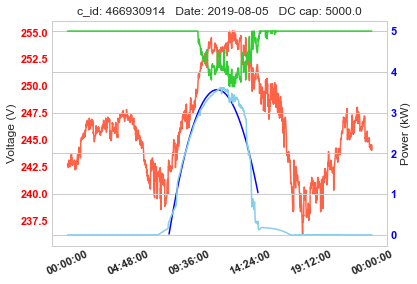

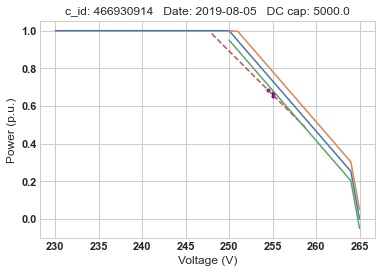

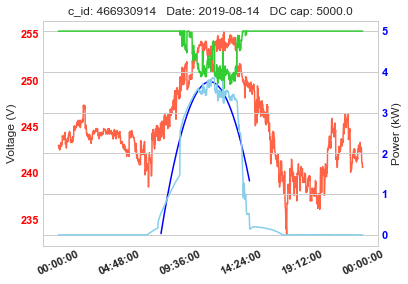

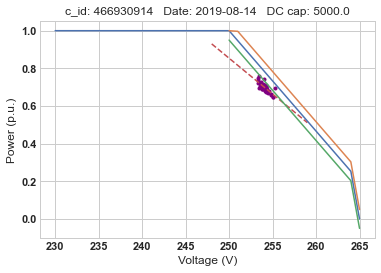

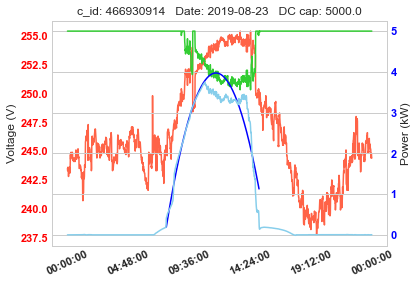

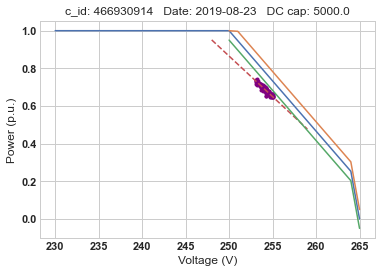

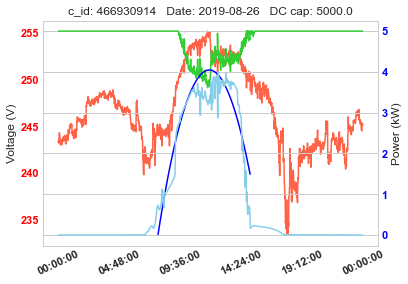

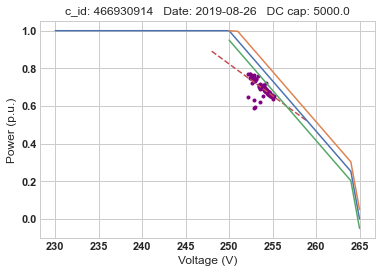

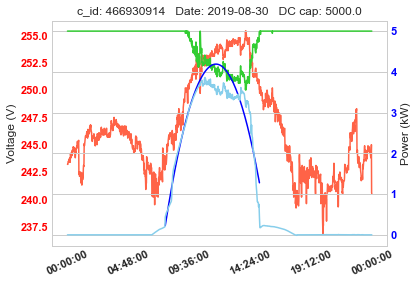

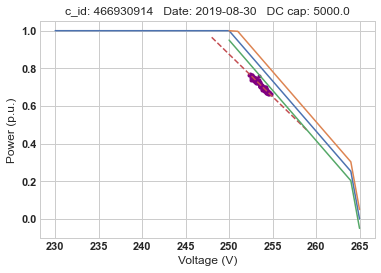

Length of sites determined to be assessable: 1

Total energy yields: 2022-09-01 16:41:30.350257

count: 1


C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:595: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['utc_tstamp'] = c_data.apply(lambda row: remove_tstamp_ms(row['utc_tstamp']), axis=1)



Volt-Watt assessment of combined datapoints: 2022-09-01 16:41:34.468657

FOR4 buffer: 0.08


Volt-Watt sites: 0 = 0.0%
NON Volt-Watt sites: 0 = 0.0%
Not enough points to assess: 0
Total sites: 1

Finished: 2022-09-01 16:41:34.468657. Time taken: 0:00:00

dict_keys([])

Analysing Date: 2019_08


5 clear sky days detected.
['2019-08-05', '2019-08-14', '2019-08-23', '2019-08-26', '2019-08-30']

Loading csv files: 2022-09-01 16:41:36.743732


Filtering clear sky data: 2022-09-01 16:41:54.361884



C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(tmp_df, ignore_index=True)



Finding over-voltage sites: 2022-09-01 16:42:04.016710


Organising sites: 2022-09-01 16:42:04.016710


Curtailment for date: 2019_08




C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)


NameError: name 'site_id_dict' is not defined

In [99]:
vwatt_response, vwatt_curt_energy = check_vwatt_curtailment(is_clear_sky_day, month, date, site_id, unique_cids)

Above error happens in some days. TODO: Debug this so it can be used in all sample (random date and site_id)

In [97]:
summary = summarize_result_into_dataframe(c_id, date, energy_generated, is_clear_sky_day, tripping_response, tripping_curt_energy, vvar_response, vvar_curt_energy, vwatt_response, vwatt_curt_energy)

summary

,c_id,date,energy generated (kWh),clear sky day,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,466930914,2019-08-14,18.9686,True,None,0,Yes,0.0,Inconclusive,NaN


# BUGS LIST
## IMPORTANT
1. Naomi's calculation of generated energy (kWh) daily is different from Baran's (probably dataset issue? cleaning issue?)
2. Tim's polyfit sometime underestimate the expected generation without curtailment, so the curtailed energy is always negative
3. No sunrise and sunset data from Baran's data, while it is used in Naomi's code
4. Trippping curtailment calculated using Baran's dataset (processed_unsw_201909_data_raw) is different from using Naomi's dataset (which I don't have) so I can't test
5. How to make sure that estimated tripping_curt_energy doesn't include VVAr and VWatt?
6. Incomplete dataset? Only midnight data, eg on 2020-03-01, c_id = 1317822057
7. Tripping case not detected by Naomi's script? eg on 2020-03-02, c_id = 1317822057. Also on '2019-07-21' c_id 1317822057
8. Adding bug no. 1, Tim's calculation of generated energy is also different from Baran's and Naomi's!!

# BUG 6. INCOMPLETE DATASET


In [ ]:
data_date_idx = '202003'
file_path = r"C:\Users\samha\Documents\CANVAS\data"
data_path = file_path + r"\processed_unsw_" + data_date_idx + '_data_raw.csv'
data = pd.read_csv(data_path, index_col = 1)

# Convert timestamp to local Adelaide time
data.index = pd.to_datetime(data.index) # convert index from object type to datetime
Adelaide_local_time = pytz.timezone('Australia/Adelaide')
data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
data.index.rename('Timestamp', inplace = True)

date = '2020-03-01'
date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
data = data[data.index.date == date_dt] #focus only on the date

data [ data['c_id'] == 1317822057]

# OTHER SCRIPTS

# MESSY BELOW

In [105]:

total_energy_yield_dict = {}

plt.interactive(False)
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 10)


site_id_list_235 = None
#dates = ["2019_07", "2019_08", "2019_09", "2019_10", "2019_11", "2019_12", "2020_01", "2020_02", "2020_03", "2020_04"]
dates = ["2019_08"]

overall_volt_watt_dict = {}

overall_clear_sky_days_dict = {}

# FIRST PASS AGGREGATIONG OF DATA FOR EACH SITE
def first_run(dateFile):

    
    overall_clear_sky_days_dict[dateFile] = []
    print("\nAnalysing Date: " + dateFile + "\n\n")

    ghi = pd.read_csv(file_path + r"/sl_023034_" + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

    clear_sky_days = []


    for date in separated_ghi_data.keys():
        ghi_df = separated_ghi_data[date]
        res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

        if res:
            clear_sky_days.append(date)
            overall_clear_sky_days_dict[dateFile].append(date)


    if len(clear_sky_days) == 0:
        print("No clear sky days in month: " + dateFile)
        return
    else:
        print(str(len(clear_sky_days)) + " clear sky days detected.")
        print(clear_sky_days)

    telemetry_string = Get_telemetry_string(dateFile)
    
    pers_clear_sky_days = clear_sky_days
    
    data = pd.read_csv(file_path +r"/processed_unsw_" + telemetry_string + "_data_raw.csv")
    cicuit_details = pd.read_csv(file_path+r"/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv(file_path + r"/unsw_20190701_site_details.csv")
    print("\nLOADED DATA FILE: " + str(datetime.now()) + "\n")

    print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
    clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)
    
    pers_cicuit_details = cicuit_details
    pers_site_details = site_details
    
    print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
    site_id_list_235 = [1641159822]
    
    pers_site_id_list_235 = site_id_list_235
    #pers_site_id_list_255 = site_id_list_255
    
    print("\nOrganising sites: " + str(datetime.now()) + "\n")
    overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                            cicuit_details)
    
#     print(overall_site_organiser)
#     print(type(overall_site_organiser))
#     print(overall_site_organiser.keys())
#     print(overall_site_organiser[1641159822])
    
    pers_overall_site_organiser = overall_site_organiser
    
    
    print("\nAdding Volt-Watt data: " + str(datetime.now()) + "\n")
    count = 0
    for site_id in site_id_list_235:
        
        print("count: " + str(count))
        print(site_id)
        count += 1
        Assess_Volt_Watt_behaviour_site(overall_site_organiser[site_id], clear_sky_days, overall_volt_watt_dict)
    
    print("\nTotal energy yields: " + str(datetime.now()) + "\n")
    determine_total_energy_yields(dateFile, data, overall_site_organiser)
    


Analysing Date: 2019_08


5 clear sky days detected.
['2019-08-05', '2019-08-14', '2019-08-23', '2019-08-26', '2019-08-30']

LOADED DATA FILE: 2022-09-01 16:46:50.076111


Filtering clear sky data: 2022-09-01 16:46:50.076111



C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(tmp_df, ignore_index=True)



Finding over-voltage sites: 2022-09-01 16:47:00.414563


Organising sites: 2022-09-01 16:47:00.414563



C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)



Adding Volt-Watt data: 2022-09-01 16:47:01.169073

count: 0
1641159822


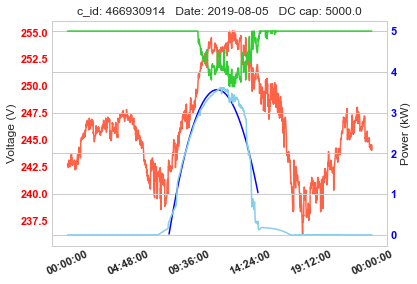

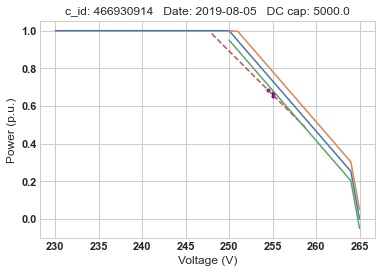

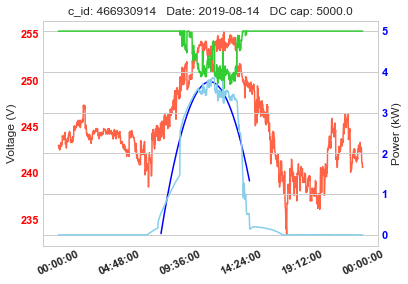

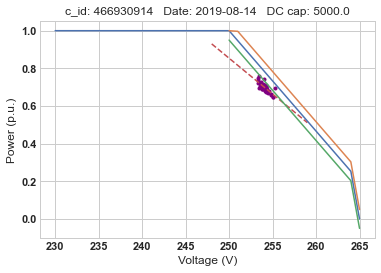

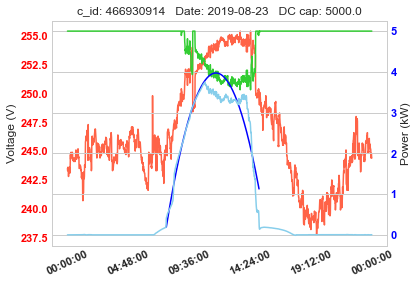

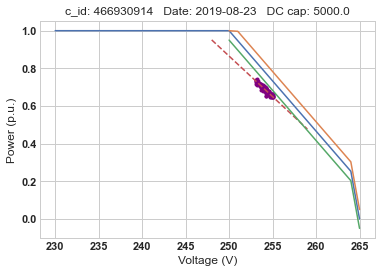

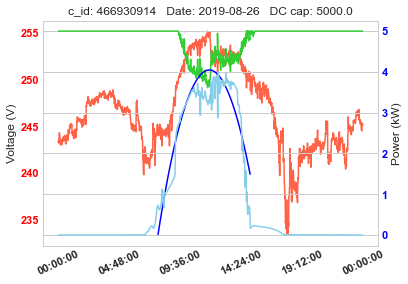

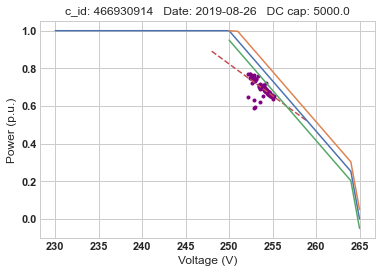

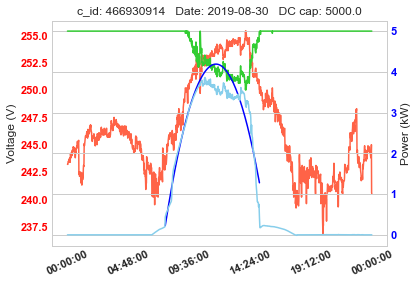

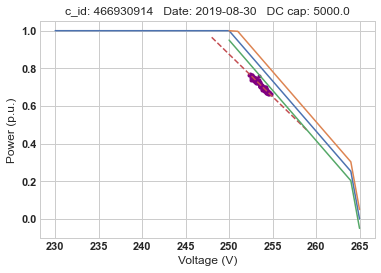

Length of sites determined to be assessable: 1

Total energy yields: 2022-09-01 16:47:07.987344

count: 1


C:\Users\samha\AppData\Local\Temp\ipykernel_14356\2624693942.py:595: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['utc_tstamp'] = c_data.apply(lambda row: remove_tstamp_ms(row['utc_tstamp']), axis=1)


In [106]:
first_run("2019_08")

In [108]:
overall_volt_watt_dict

{466930914: {'v': [254.5,
   255.0,
   255.1,
   253.9,
   254.0,
   254.0,
   254.2,
   254.1,
   253.9,
   253.9,
   253.8,
   254.1,
   253.8,
   253.9,
   253.9,
   253.7,
   253.6,
   253.9,
   254.0,
   253.7,
   253.8,
   254.2,
   254.1,
   253.4,
   253.8,
   254.2,
   253.8,
   253.6,
   253.4,
   253.3,
   253.3,
   253.3,
   253.7,
   254.0,
   254.1,
   253.9,
   253.9,
   253.8,
   254.2,
   253.9,
   254.0,
   253.8,
   253.9,
   254.3,
   254.1,
   254.6,
   254.8,
   254.8,
   254.1,
   254.3,
   254.2,
   254.1,
   254.3,
   254.4,
   254.1,
   254.3,
   254.3,
   254.5,
   254.3,
   254.5,
   254.3,
   254.4,
   254.5,
   255.0,
   255.3,
   255.1,
   253.2,
   253.1,
   253.1,
   253.3,
   253.1,
   253.2,
   253.4,
   253.5,
   253.3,
   253.1,
   253.2,
   253.3,
   253.2,
   253.2,
   253.7,
   254.0,
   253.8,
   254.1,
   253.7,
   253.6,
   253.8,
   253.7,
   253.6,
   253.1,
   253.6,
   253.9,
   254.1,
   254.1,
   254.1,
   254.2,
   253.7,
   253.8,
   2

In [112]:
site_id_list_235 = None
#dates = ["2019_07", "2019_08", "2019_09", "2019_10", "2019_11", "2019_12", "2020_01", "2020_02", "2020_03", "2020_04"]
dates = ["2019_08"]
dates = [month[:4] + "_" + month[4:]]

overall_volt_watt_dict = {}

overall_clear_sky_days_dict = {}
first_run(dates_not_list)


Analysing Date: 2020_04


4 clear sky days detected.
['2020-04-08', '2020-04-09', '2020-04-13', '2020-04-24']

LOADED DATA FILE: 2022-09-01 16:54:01.979049


Filtering clear sky data: 2022-09-01 16:54:01.979049



C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(tmp_df, ignore_index=True)



Finding over-voltage sites: 2022-09-01 16:54:10.263100


Organising sites: 2022-09-01 16:54:10.263100



C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)
C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150

C:\Users\samha\AppData\Local\Temp\ipykernel_14356\1041711150.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)

KeyboardInterrupt



In [ ]:
overall_volt_watt_dict